コードが動かない場合にはAPIやライブラリ等がアップデートしている可能性があります。その際には以下のGitHubページにて更新情報がないかご確認ください。

https://github.com/tamanome/satelliteBook

# 農業分野における衛星データ利用事例

## この章で学習すること

本章では、茨城県を対象として、過去約10年間のMODISデータを解析することで米の収量予測にチャレンジします。

*   `pyMODIS`　を用いたMODIS衛星画像処理
*   `gdal` & `numpy` を用いた画像処理
*   `rasterstat` を用いた画像における統計情報の取得

###必要なライブラリのインストール

In [ ]:
!pip install pyMODIS
!pip install geopandas
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install scikit-learn
!pip install xarray
!pip install rioxarray
# !pip install modis-tools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 71.9 MB/s eta 0:00:00


### ライブラリのインポート

基礎分野でご紹介した`GDAL`ライブラリは、地理空間データを扱う上で基礎となる重要なライブラリですが、GISの概念に慣れていないと理解しにくいパラメータがたくさん登場するため、衛星データを触り始めたばかりの頃は複雑に感じることもあるかと思います。

この教材では、地理空間データの処理がより便利になるPythonのライブラリをいくつかご紹介します。

* [numPy](https://github.com/numpy/numpy)

    `numpy`は、数値計算を効率的に行うための拡張モジュールです。基本的な計算はpythonだけでも出来ますが、numpyを使うとその計算が高速になったり、より楽になったりします。多次元配列を必要とする処理において、特にその機能を発揮するライブラリです。

* [GeoPandas](https://github.com/geopandas/geopandas)

    有名なデータ処理ライブラリ`pandas`を、地理情報が取り扱いできるように拡張したライブラリです。`pandas`と同じ強力なデータ処理機能を持つだけでなく、他の地理空間データとの連携が可能です。

* [matplotlib](https://github.com/matplotlib/matplotlib)  

    `matplotlib`は、Pythonでグラフや図を描画、作成するための包括的なライブラリです。折れ線グラフやヒストグラムといった2次元グラフだけなく3次元のグラフも描画することが可能です。

* [pyMOIDS](https://github.com/lucadelu/pyModis)  

    `pyMOIDS`は、GNU GPL 2によって管理されているライブラリで、NASAが運用する衛星センサ"MODIS"のデータ処理専用のライブラリです。NASAのサーバから直接MODISデータをダウンロードして投影変換などの処理することが可能です。

* [scikit-learn](https://github.com/lucadelu/pyModis)  

    `scikit-learn`は、オープンソースで公開されている機械学習用のライブラリです。誰でも無償で利用することが可能であり、分類/回帰/クラスタリングといったモデルを作成することが可能です。











In [ ]:
# Google Colab利用時のみ
# ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#必要ライブラリをインポート
import os
import glob
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import shutil
import pandas as pd
import geopandas as gpd
import csv
import requests,urllib
import rasterio as rio
import fiona
import time
from tqdm import tqdm

from pymodis import downmodis
from pymodis.convertmodis_gdal import convertModisGDAL
from osgeo import gdal, gdalconst, gdal_array, osr
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
matplotlib.rcParams['figure.dpi'] = 300 # 解像度

print("done")

done


## 衛星データの取得

この章では、アメリカ航空宇宙局（NASA）が運用するTerra衛星およびAqua衛星に搭載されている光学センサ「MODIS」が取得するデータを使用します。このデータは誰でも無償で利用することが可能です。

### API経由のデータ取得

APIを使ってMODISのデータをダウンロードするためには、[NASAのEARTH DATA](https://urs.earthdata.nasa.gov/)にアクセスして、ユーザー登録をしてください。

本章では、2007年から2017年までのMODISのデータを解析して収量を予測する式を作成し、2018年のデータで検証してみます。

そこで、NASAのLP DAAC (Land Processes Distributed Active Archive Center) よりAPI経由でデータをダウンロードし、対象期間のデータセットを作成します。


In [ ]:
#解析対象期間の指定とデータ保存用ディレクトリ（フォルダ）の作成

listYears = ["2007","2008","2009","2010","2011","2012","2013","2014","2015","2016","2017","2018"]

if os.path.exists('average_EVI'):
  print("done")
else:
  os.mkdir("average_EVI")
  print("done")

done


本章では、Vegetation Indices 16-Day L3 Global 250mプロダクトを使用します。このプロダクトは、日別のEVIデータ16日分を合成することで雲の影響を減少させたものです。MODISのデータはほぼ毎日取得されますが、このプロダクトは16日ごとに提供されています。

また、プロダクト画像はシヌソイダル座標系で区切られ、各地域によってタイル番号が振られています。タイル番号については[こちら](https://modis-land.gsfc.nasa.gov/MODLAND_grid.html)を参照してください。

[pyModis](http://www.pymodis.org)を利用し、データをダウンロードしてその中身について簡単に説明を行います。

In [ ]:
# ダウンロードに必要な変数
dest = os.getcwd() # ダウンロードフォルダの指定。適宜変えてください
tiles = "h29v05" # 日本の一部を覆うタイルを指定
day = "2015-11-30" #todayの引数
enddate = "2015-10-10" # 必ずtoday以前の日付にしてください。downModisでは時間を遡る形で検索をしていきます
product = "MOD13Q1.061" #20240409: The file path was changed from "MOD13Q1.006" to "MOD13Q1.061"
name = "jumpeitakami" # ユーザー名を「””」の中に記入してください
passwd = "ASFlkara907!" # アカウントパスワードを「””」の中に記入してください

# ダウンロード開始
modis_down = downmodis.downModis(destinationFolder=dest, tiles=tiles, today=day, enddate=enddate, user=name, password=passwd, product=product)
modis_down.connect()
modis_down.downloadsAllDay()

取得したデータは、HDF (Hierarchical Data Format)と呼ばれる階層型データフォーマットと呼ばれるものになります。そのため、衛星が持っている一つ一つのデータは各々の階層中にあるため、必要なデータを指定する必要があります。

In [ ]:
g = gdal.Open("/content/MOD13Q1.A2015321.h29v05.061.2021337060254.hdf") # hdfの読み込み
# Also, the hdf file name was changed from "2015343135821.hdf" to "2021337060254.hdf"
subdatasets = g.GetSubDatasets() #データセットの取得
print(len(subdatasets))
# print(subdatasets)
l = []
# l.extend([s[0] for s in subdatasets if "250m 16 days EVI" in s[0].split(':')[-1]]) # SDS名の取得
l.extend([s[0].split(':')[-1] for s in subdatasets])
l

12


['"250m 16 days NDVI"',
 '"250m 16 days EVI"',
 '"250m 16 days VI Quality"',
 '"250m 16 days red reflectance"',
 '"250m 16 days NIR reflectance"',
 '"250m 16 days blue reflectance"',
 '"250m 16 days MIR reflectance"',
 '"250m 16 days view zenith angle"',
 '"250m 16 days sun zenith angle"',
 '"250m 16 days relative azimuth angle"',
 '"250m 16 days composite day of the year"',
 '"250m 16 days pixel reliability"']

結果を見てわかるように、MOD13Q1は12の[サブデータ（レイヤー）](https://lpdaac.usgs.gov/products/mod13q1v006/)に分かれています。植生の活性度を調べるのであれば、NDVIとEVIのどちらかを取得するということになります。

レイヤーを指定して、TIFF画像を作成しましょう。

In [ ]:
hdfName = "/content/MOD13Q1.A2015321.h29v05.061.2021337060254.hdf" # 読み込みフィイル名
prefix = os.path.join(os.getcwd(),hdfName[18:25]) # 接頭辞の指定。ファイルは xxx_レイヤー名となります
subset = [0,1,0,0,0,0,0,0,0,0,0,0] # EVI
convertsingle = convertModisGDAL(hdfname=hdfName, prefix=prefix, subset=subset, res=250, outformat="GTiff", epsg=32654)
convertsingle.run()

Layer HDF4_EOS:EOS_GRID:"/content/MOD13Q1.A2015321.h29v05.061.2021337060254.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days EVI" reprojected
All layer for dataset '/content/MOD13Q1.A2015321.h29v05.061.2021337060254.hdf' reprojected


現在のフォルダに、2015321_250m 16 days EVIが作成されたはずです。

一般的に水稲収量を予測する際には植生指標の積算値が用いられますが、本章では水稲の植生指数が最も高くなる8月と9月で2時期のEVIを平均化して代表値とします。また、8月と9月それぞれの代表プロダクトは画像を見て適切な組み合わせを選択しました。

ダウンロードしたデータにはそれぞれ異なるプロダクトがHDF形式で格納されているので、上記プロダクトを抜き出し、UTM zone 54Nの座標系を与え、GeoTIFF形式で保存します。

上記の流れを関数として定義し、2007年から2018年までのデータ取得からEVI画像の作成までを一貫して行いましょう。

In [ ]:
class modisEviTiff:
  def __init__(self,dstFolder,outFolder,tileId,sDate,eDate,user,passwd,product,epsg,res=250,outformat='GTiff'):
    """
    Args
      dstFolder: EVIファイルのフォルダを指定
      outFolder: 出力ファイルの指定
      tileId: 取得するタイルIDを指定
      startDate: データ取得開始日
      endDate: データ取得終了日
      user: ユーザ名
      passwd: パスワード名
      product: 取得するプロダクト
      epsg: EPSGの指定
      res: 解像度の指定　(MCD13Q1は250m)
      outformat: 出力フォーマット （初期はGeoTIFF)
    """
    self.dstFolder = dstFolder
    self.outFolder = outFolder
    self.tileId = tileId
    self.sDate = sDate
    self.eDate = eDate
    self.user = user
    self.passwd = passwd
    self.product = product
    self.epsg = epsg
    self.res = res
    self.outformat = outformat

  def download(self):
    """HDFデータをEarth Dataからダウンロードする
    Args
      None
    Returns
      None
    """
    modis_down = downmodis.downModis(destinationFolder=self.dstFolder,tiles=self.tileId,today=self.eDate,enddate=self.sDate,user=self.user,password=self.passwd,product=self.product)
    modis_down.connect() # サーバへの接続
    modis_down.downloadsAllDay() #  該当の日付から全てのデータをダウンロード
    # 使用するデータの選択
    hdf_list = glob.glob(os.path.join(self.dstFolder,'*.hdf'))
    # HDFからTiff画像の作成
    for f in hdf_list:
      prefix = os.path.join(self.dstFolder,f) # prefixの指定
      subset = [0,1,0,0,0,0,0,0,0,0,0,0] # EVI
      convertsingle = convertModisGDAL(hdfname=f, prefix=prefix, subset=subset,res=self.res, outformat=self.outformat, epsg=self.epsg)
      convertsingle.run() # 実行

  def calcAvg(self):
    """作成したtif画像から年ごとの平均値画像を作成
    Args
      None
    Returns
      None
    """

    EVI_list = glob.glob(os.path.join(self.dstFolder, '*.tif')) # 作成したtif画像の読み込み

    # 取得画像からモザイク画像を作成するための情報を取得
    src = gdal.Open(EVI_list[1],gdalconst.GA_ReadOnly) # ラスター画像を開く
    img = np.array(src.ReadAsArray()).astype(np.float32) # 配列情報を取得。全データで共通
    pixel=img.shape[0] # 画像の幅
    line=img.shape[1] # 画像の高さ
    # 値を入れるための空の配列を準備します
    base_array = np.zeros((pixel,line))

    for EVI in EVI_list:
      print("OPEN" + EVI)
      # gdal.Openしたデータはosgeo.gdal.Datasetになります。今回はバンドを絞って取得していますが、しなければ複数のバンド情報をもったクラスになります
      data = gdal.Open(EVI, gdalconst.GA_ReadOnly)
      imgs = np.array(data.ReadAsArray()).astype(np.float32) # バンドの情報をnumpy.ndarrayにする
      base_array = base_array + imgs # 画像情報の挿入

    EVI_avg = base_array/len(EVI_list) # 平均値の導出
    # scaledEvi = EVI_ave*0.0001 # スケーリング
    xsize = src.RasterXSize # 画像の幅
    ysize = src.RasterYSize # 画像の高さ

    # ダウンロードパスは適宜変更
    dst = os.path.join(self.outFolder, "EVI_average_" + self.sDate[0:4] + ".tif")
    driver = gdal.GetDriverByName('GTiff') # geotiffを作るためのドライバーを設定
    dst_raster = driver.Create(dst, xsize, ysize, 1, gdal.GDT_Int16) # 画像を作成するための情報を入力

    dst_raster.SetProjection(src.GetProjection()) # {出力変数}.SetProjection(座標系情報)
    dst_raster.SetGeoTransform(src.GetGeoTransform()) # {出力変数}.SetGeoTransform(座標に関する６つの数字)

    dst_band = dst_raster.GetRasterBand(1)
    dst_band.WriteArray(EVI_avg)
    dst_band.FlushCache() # キャッシュの削除
    dst_raster = None
    print("done")

In [ ]:
[os.makedirs("/content/drive/MyDrive/MOD13Q1/"+ylist,exist_ok=True) for ylist in listYears] # 画像保存用フォルダ作成

[None, None, None, None, None, None, None, None, None, None, None, None]

In [ ]:
# 2007年〜2011年と2015年〜2018年のデータから取得します
selYears = ['2007','2008','2009','2010','2011','2015','2016','2017','2018', '2019']
destFolders = []
for element in selYears:
  path = "/content/drive/MyDrive/MOD13Q1" # 適宜変更
  destFolders.append(os.path.join(path,element))

startDates = "-09-01 ".join(selYears).split(" ")[0:9]
endDates = "-09-30 ".join(selYears).split(" ")[0:9]

os.makedirs("/content/drive/MyDrive/average_EVI", exist_ok=True) # 出力フォルダ

product = "MOD13Q1.061"
name =  "jumpeitakami" # ユーザー名を「””」の中に記入してください
passwd = "ASFlkara907!" # アカウントパスワードを「””」の中に記入してください
outputPath = "/content/drive/MyDrive/average_EVI/" # 出力フォルダ指定

for index, destination in enumerate(destFolders[0:9]):
  sDay = startDates[index]
  eDay = endDates[index]
  modisEvi = modisEviTiff(dstFolder=destination, outFolder=outputPath,
                          tileId=tiles, sDate = sDay, eDate=eDay,
                          user = name, passwd = passwd,
                          product = product, epsg = 32654)
  modisEvi.download()
  modisEvi.calcAvg()

Layer HDF4_EOS:EOS_GRID:"/content/drive/MyDrive/MOD13Q1/2007/MOD13Q1.A2007273.h29v05.061.2021076145608.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days EVI" reprojected
All layer for dataset '/content/drive/MyDrive/MOD13Q1/2007/MOD13Q1.A2007273.h29v05.061.2021076145608.hdf' reprojected
Layer HDF4_EOS:EOS_GRID:"/content/drive/MyDrive/MOD13Q1/2007/MOD13Q1.A2007257.h29v05.061.2021074210255.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days EVI" reprojected
All layer for dataset '/content/drive/MyDrive/MOD13Q1/2007/MOD13Q1.A2007257.h29v05.061.2021074210255.hdf' reprojected
OPEN/content/drive/MyDrive/MOD13Q1/2007/MOD13Q1.A2007273.h29v05.061.2021076145608.hdf_250m-16-days-evi.tif
OPEN/content/drive/MyDrive/MOD13Q1/2007/MOD13Q1.A2007257.h29v05.061.2021074210255.hdf_250m-16-days-evi.tif
done
Layer HDF4_EOS:EOS_GRID:"/content/drive/MyDrive/MOD13Q1/2008/MOD13Q1.A2008273.h29v05.061.2021108163230.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days EVI" reprojected
All layer for dataset '/content/drive/

In [ ]:
# 2012年〜2014年のデータも取得します
selYears = ['2012','2013','2014','2015']
destFolders = []
for element in selYears:
  path = "/content/drive/MyDrive/MOD13Q1/"# 適宜変更
  destFolders.append(os.path.join(path,element))

startDates = "-08-25 ".join(selYears).split(" ")[0:3]
endDates = "-09-20 ".join(selYears).split(" ")[0:3]

for index, destination in enumerate(destFolders[0:3]):
  sDay = startDates[index]
  eDay = endDates[index]
  modisEvi = modisEviTiff(dstFolder=destination, outFolder=outputPath,
                          tileId=tiles, sDate = sDay, eDate=eDay,
                          user = name, passwd = passwd,
                          product = product, epsg = 32654)
  modisEvi.download()
  modisEvi.calcAvg()

Layer HDF4_EOS:EOS_GRID:"/content/drive/MyDrive/MOD13Q1/2012/MOD13Q1.A2012257.h29v05.061.2021215164800.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days EVI" reprojected
All layer for dataset '/content/drive/MyDrive/MOD13Q1/2012/MOD13Q1.A2012257.h29v05.061.2021215164800.hdf' reprojected
Layer HDF4_EOS:EOS_GRID:"/content/drive/MyDrive/MOD13Q1/2012/MOD13Q1.A2012241.h29v05.061.2021215105143.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days EVI" reprojected
All layer for dataset '/content/drive/MyDrive/MOD13Q1/2012/MOD13Q1.A2012241.h29v05.061.2021215105143.hdf' reprojected
OPEN/content/drive/MyDrive/MOD13Q1/2012/MOD13Q1.A2012257.h29v05.061.2021215164800.hdf_250m-16-days-evi.tif
OPEN/content/drive/MyDrive/MOD13Q1/2012/MOD13Q1.A2012241.h29v05.061.2021215105143.hdf_250m-16-days-evi.tif
done
Layer HDF4_EOS:EOS_GRID:"/content/drive/MyDrive/MOD13Q1/2013/MOD13Q1.A2013257.h29v05.061.2021240010736.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days EVI" reprojected
All layer for dataset '/content/drive/

サンプルとして2007年におけるEVI平均値画像を表示してみましょう。


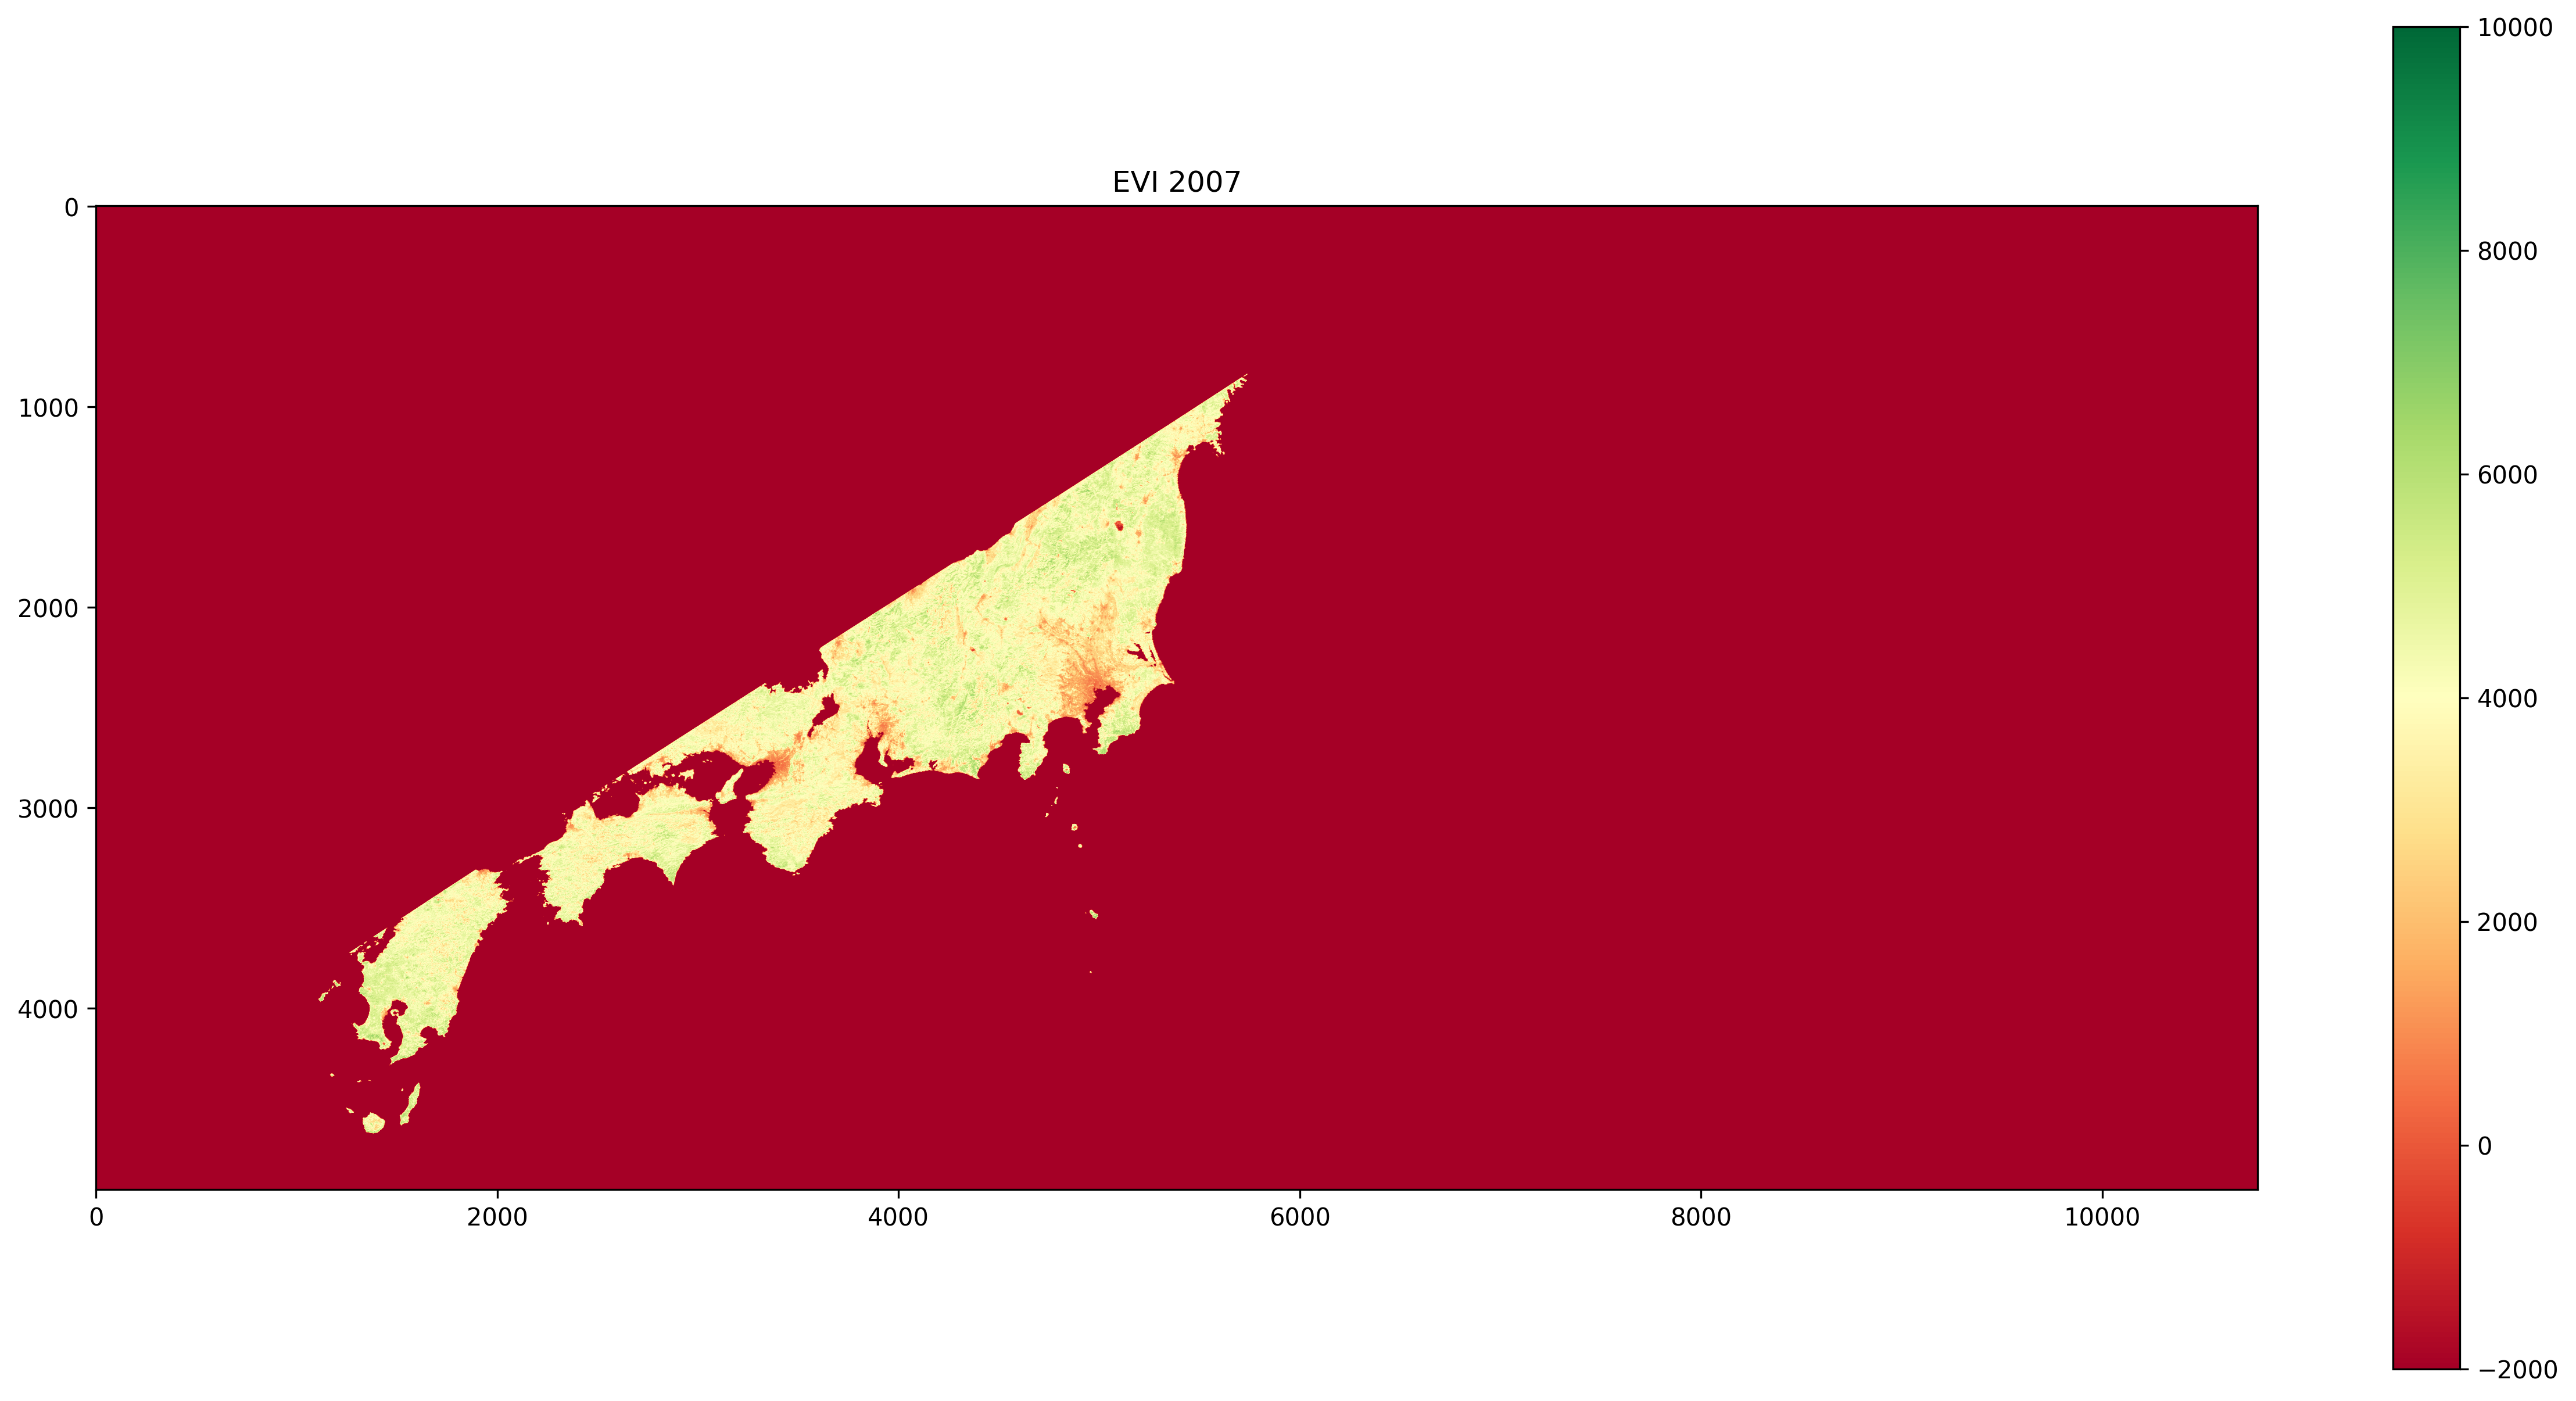

In [ ]:
EVI_image = gdal.Open("/content/drive/MyDrive/average_EVI/EVI_average_2007.tif")

EVI_array = EVI_image.ReadAsArray()

plt.figure(figsize=(20,10))
plt.imshow(EVI_array,vmin=-2000,vmax=10000,cmap='RdYlGn')

plt.title("EVI 2007")
plt.colorbar()
plt.show()

上の画像ではEVIの範囲を-2000から10000で表示しています。
画像において緑色が強いほど植物の活性が高いことを示しており、赤が強いほど植生が少ないことを示しています。
また、水域が赤く染まっていますが、こちらは水域を下限である-2000であることを示しています。

画像を見ると、東京都や神奈川県などの都市部においては赤色が強く、植生が少ないことが見て取れます。

## 水田域におけるEVIの集計


今回の解析では、茨城県を対象に水稲の収量を予測します。茨城県全域のEVIを解析すると、水田以外に畑や森林の植生も入ってしまうので、水田以外をマスク（隠す）した上で、水田域におけるEVIの平均値を計算します。

### 筆ポリゴンの取得

マスク処理には、農林水産省が提供している農地の区画情報である「筆ポリゴン」を使用します。筆ポリゴンは、都道府県あるいは市町村単位で提供されているGISデータ（Shapefile）です。

本来ならば、解析する年ごとに筆ポリゴンを入手する必要がありますが、過去のアーカイブは提供されていません。今回は、過去10年間の農地の変化は誤差の範囲として割り切り、提供されている最新版の筆ポリゴンを使って過去のEVIもマスクすることにします。

農林水産省ウェブサイトの[筆ポリゴンダウンロードページ](https://www.maff.go.jp/j/tokei/porigon/hudeporidl.html)から、茨城県の筆ポリゴンデータをダウンロードしましょう。zip形式で圧縮されたファイルを解凍すると、市町村単位のフォルダでファイルが格納されています。

＊ダウンロード先のURLが変わったことにより、wgetが失敗することがあります。wgetでエラーが生じた場合は上記のダウンロードページでリンクを確認してください。


In [ ]:
# 筆ポリゴンをダウンロードするフォルダの作成
os.makedirs('fudePoly',exist_ok=True)

# wgetを行います。UA (User Agentを付けてダウンロードしましょう)
# 数分時間がかかります
!wget --restrict-file-names=nocontrol \
     --content-disposition \
     --user-agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:52.0) Gecko/20100101 Firefox/52.0" \
     "http://www.machimura.maff.go.jp/polygon/08%E8%8C%A8%E5%9F%8E%E7%9C%8C%EF%BC%882021%E5%85%AC%E9%96%8B%EF%BC%89.zip" \
     -P /content/fudePoly

--2024-04-10 08:16:53--  http://www.machimura.maff.go.jp/polygon/08%E8%8C%A8%E5%9F%8E%E7%9C%8C%EF%BC%882021%E5%85%AC%E9%96%8B%EF%BC%89.zip
Resolving www.machimura.maff.go.jp (www.machimura.maff.go.jp)... 13.35.35.120, 13.35.35.48, 13.35.35.10, ...
Connecting to www.machimura.maff.go.jp (www.machimura.maff.go.jp)|13.35.35.120|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.machimura.maff.go.jp/polygon/08%E8%8C%A8%E5%9F%8E%E7%9C%8C%EF%BC%882021%E5%85%AC%E9%96%8B%EF%BC%89.zip [following]
--2024-04-10 08:16:53--  https://www.machimura.maff.go.jp/polygon/08%E8%8C%A8%E5%9F%8E%E7%9C%8C%EF%BC%882021%E5%85%AC%E9%96%8B%EF%BC%89.zip
Connecting to www.machimura.maff.go.jp (www.machimura.maff.go.jp)|13.35.35.120|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2024-04-10 08:16:53 ERROR 403: Forbidden.



続けて、ダウンロードしたファイルを解凍しましょう。

shutilを使う方法もありますが、文字化けを防ぐためにやや長いコードになっています。

In [ ]:
import zipfile
# 参考：
## https://www.shibutan-bloomers.com/python_libraly_zip_shutil/1402/
## https://qiita.com/tohka383/items/b72970b295cbc4baf5ab

with zipfile.ZipFile('/content/drive/MyDrive/fudePoly/08茨城県（2021公開）.zip') as zipf:
  for zinfo in zipf.infolist():        # ZipInfoオブジェクトを取得
      if not zinfo.flag_bits & 0x800:  # flag_bitsプロパティで文字コードを取得
          # 文字コードが(cp437)だった場合はcp932へ変換する
          # strオブジェクトのプロパティencode/decodeでcp932に変換
          # 変換後のファイル名をfilenameプロパティで再度し直す
          zinfo.filename = zinfo.filename.encode('cp437').decode('cp932')
          if os.sep != "/" and os.sep in zinfo.filename:
            zinfo.filename = zinfo.filename.replace(os.sep, "/")

      zipf.extract(zinfo, '/content/fudePoly')

ダウンロードしたファイルを全て、同じ階層に持っていきます。

In [ ]:
# bashを利用します
!find -regextype egrep -regex ".*\.(dbf|shx|shp|prj)" -exec mv {} fudePoly \;

In [ ]:
# shpファイルのパスを取得
filepaths = glob.glob('/content/fudePoly'+'/*_5.shp')

# 中身をチェックします
print(filepaths)

['/content/fudePoly/08208龍ケ崎市（2021公開）_5.shp', '/content/fudePoly/08207結城市（2021公開）_5.shp', '/content/fudePoly/08205石岡市（2021公開）_5.shp', '/content/fudePoly/08564利根町（2021公開）_5.shp', '/content/fudePoly/08447河内町（2021公開）_5.shp', '/content/fudePoly/08302茨城町（2021公開）_5.shp', '/content/fudePoly/08309大洗町（2021公開）_5.shp', '/content/fudePoly/08204古河市（2021公開）_5.shp', '/content/fudePoly/08212常陸太田市（2021公開）_5.shp', '/content/fudePoly/08233行方市（2021公開）_5.shp', '/content/fudePoly/08217取手市（2021公開）_5.shp', '/content/fudePoly/08224守谷市（2021公開）_5.shp', '/content/fudePoly/08364大子町（2021公開）_5.shp', '/content/fudePoly/08232神栖市（2021公開）_5.shp', '/content/fudePoly/08235つくばみらい市（2021公開）_5.shp', '/content/fudePoly/08225常陸大宮市（2021公開）_5.shp', '/content/fudePoly/08214高萩市（2021公開）_5.shp', '/content/fudePoly/08227筑西市（2021公開）_5.shp', '/content/fudePoly/08443阿見町（2021公開）_5.shp', '/content/fudePoly/08521八千代町（2021公開）_5.shp', '/content/fudePoly/08216笠間市（2021公開）_5.shp', '/content/fudePoly/08230かすみがうら市（2021公開）_5.shp', '/content/fudePol

### 筆ポリゴンの編集

In [ ]:
shpList = []
for file in filepaths:
  gdf = gpd.read_file(file,encoding='shift_jis')
  gdf = gdf.to_crs(crs="epsg:32654") # CRSの変更
  shpList.append(gdf)

gdf = gpd.GeoDataFrame(pd.concat(shpList,ignore_index=True))

今回は水田が対象になりますので、「耕地の種類」を「田」にします。

In [ ]:
gdfEx = gdf[gdf['耕地の種類'] == '田']
gdfEx.shape # 約55万行あります

(543014, 5)

In [ ]:
# 日本語の変数名をアルファベット表記に変えます
ibarakiDf = gdfEx.rename(columns={'公開年度':'pYear','調製年度':'aYear','筆ポリゴン':'fudePoly','耕地の種類':'type'}).copy()

In [ ]:
# # 必要に応じて行う
# # QGISを用いてラスター化(Rasterize)を行う場合には、一つのシェープファイルからラスター化を行うのが便利です。

# 作成したGeoDataFrameをshpファイルに変換します。これにより茨城県全ての水田区画をもったshpファイルが完成します。大きなファイルですので、完成まで時間がかかります
os.makedirs('/content/fudePoly/Ibaraki',exist_ok=True)
ibarakiDf.to_file("/content/fudePoly/Ibaraki/Ibaraki.shp", encoding='utf-8')

続いて、ibarakiDfからMODISのEVI画像をくり抜く作業(Crop)を行います。

ここでは、[xarray](http://xarray.pydata.org/en/stable/)とその拡張である[rioxarray](https://corteva.github.io/rioxarray/stable/)を用いて作業をします。

In [ ]:
# 参考文献：
## https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/

# ライブラリのインポート
from shapely.geometry import mapping
import rioxarray as rxr
import xarray as xr

試しに一枚のtiff画像から、抜き作業を行ってみます。

In [ ]:
# 画像の読み込み
evi2007 = rxr.open_rasterio("/content/drive/MyDrive/average_EVI/EVI_average_2007.tif", masked=True).squeeze()
# evi2007 = rxr.open_rasterio("/content/drive/MyDrive/average_EVI/EVI_average_2007.tif").squeeze()

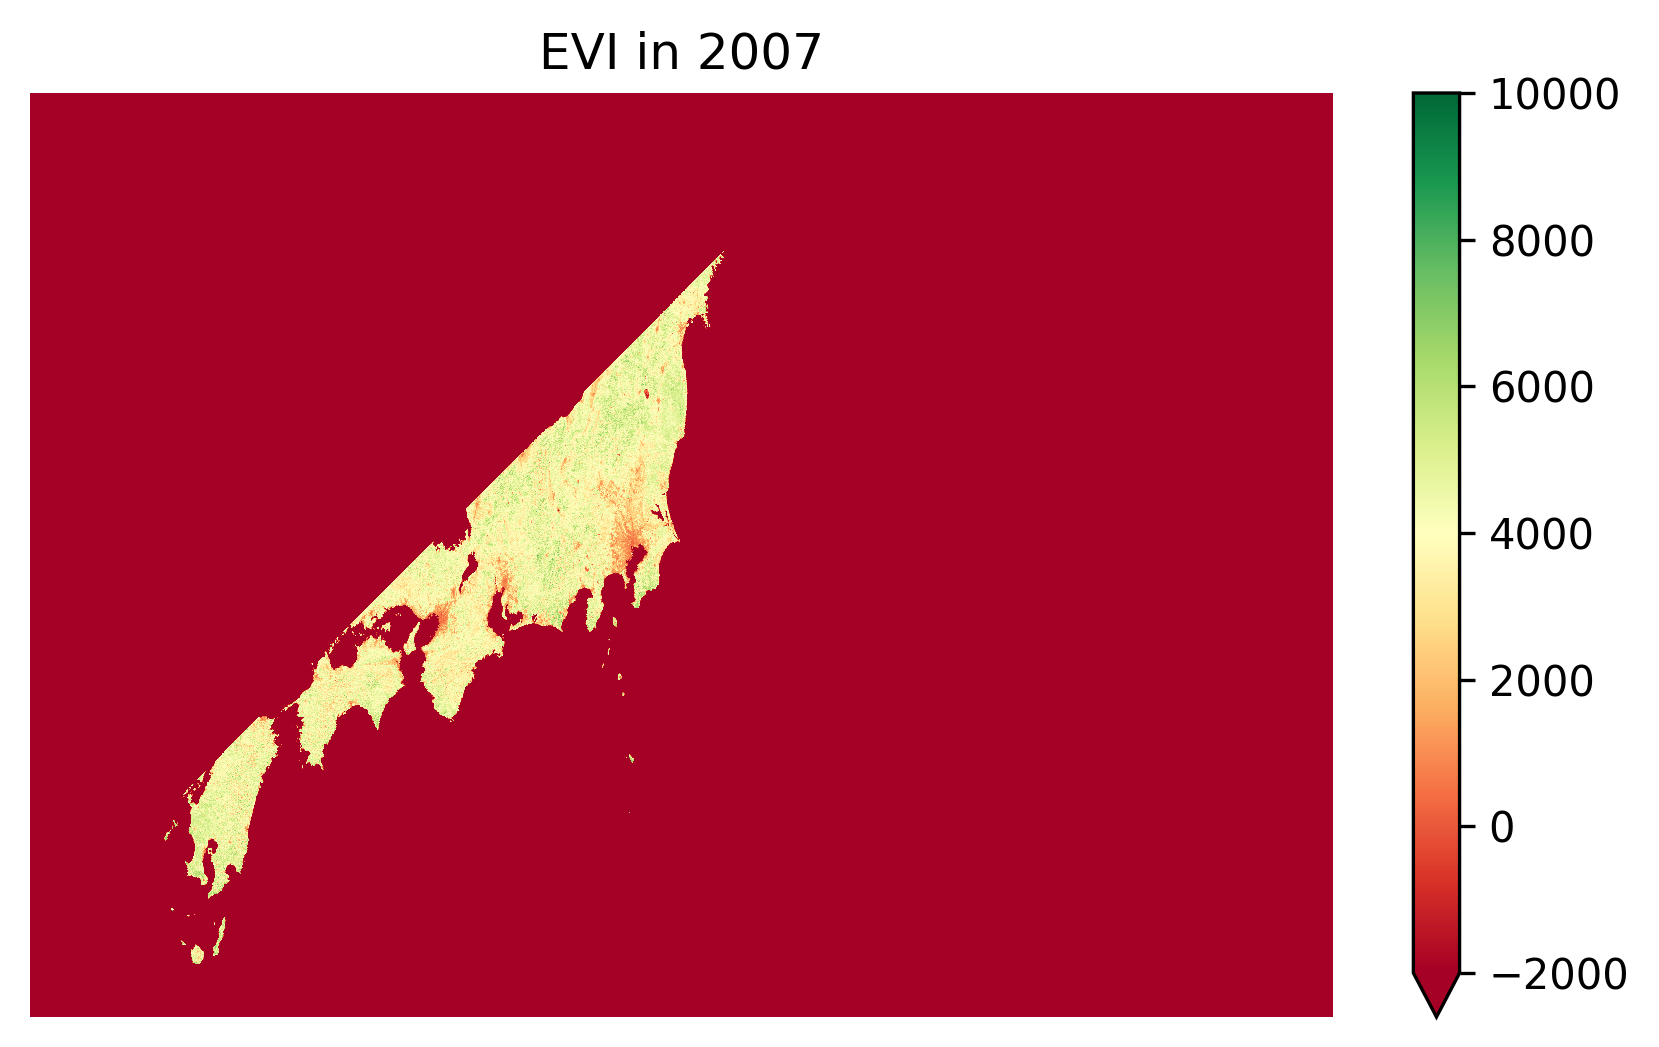

In [ ]:
f, ax = plt.subplots(figsize=(7, 4))
evi2007.plot.imshow(vmin=-2000,vmax=10000,cmap='RdYlGn')
# evi2007.plot.imshow()
ax.set(title="EVI in 2007")

ax.set_axis_off()
plt.show()

In [ ]:
# 二つのCRSを確認
print('茨城県の水田ベクター: ', ibarakiDf.crs)
print('2007年のEVI画像: ', evi2007.rio.crs)

茨城県の水田ベクター:  epsg:32654
2007年のEVI画像:  EPSG:32654


上図を見ればわかりますが、茨城県の筆ポリゴンはダウンロードしてきたMODISのEVI画像の一部であることがわかります。このような図であると、衛星画像において対象領域を絞ることの重要性がわかると同時に、ベクターデータ（shpのような）をうまく利用することが大事であることがわかります。

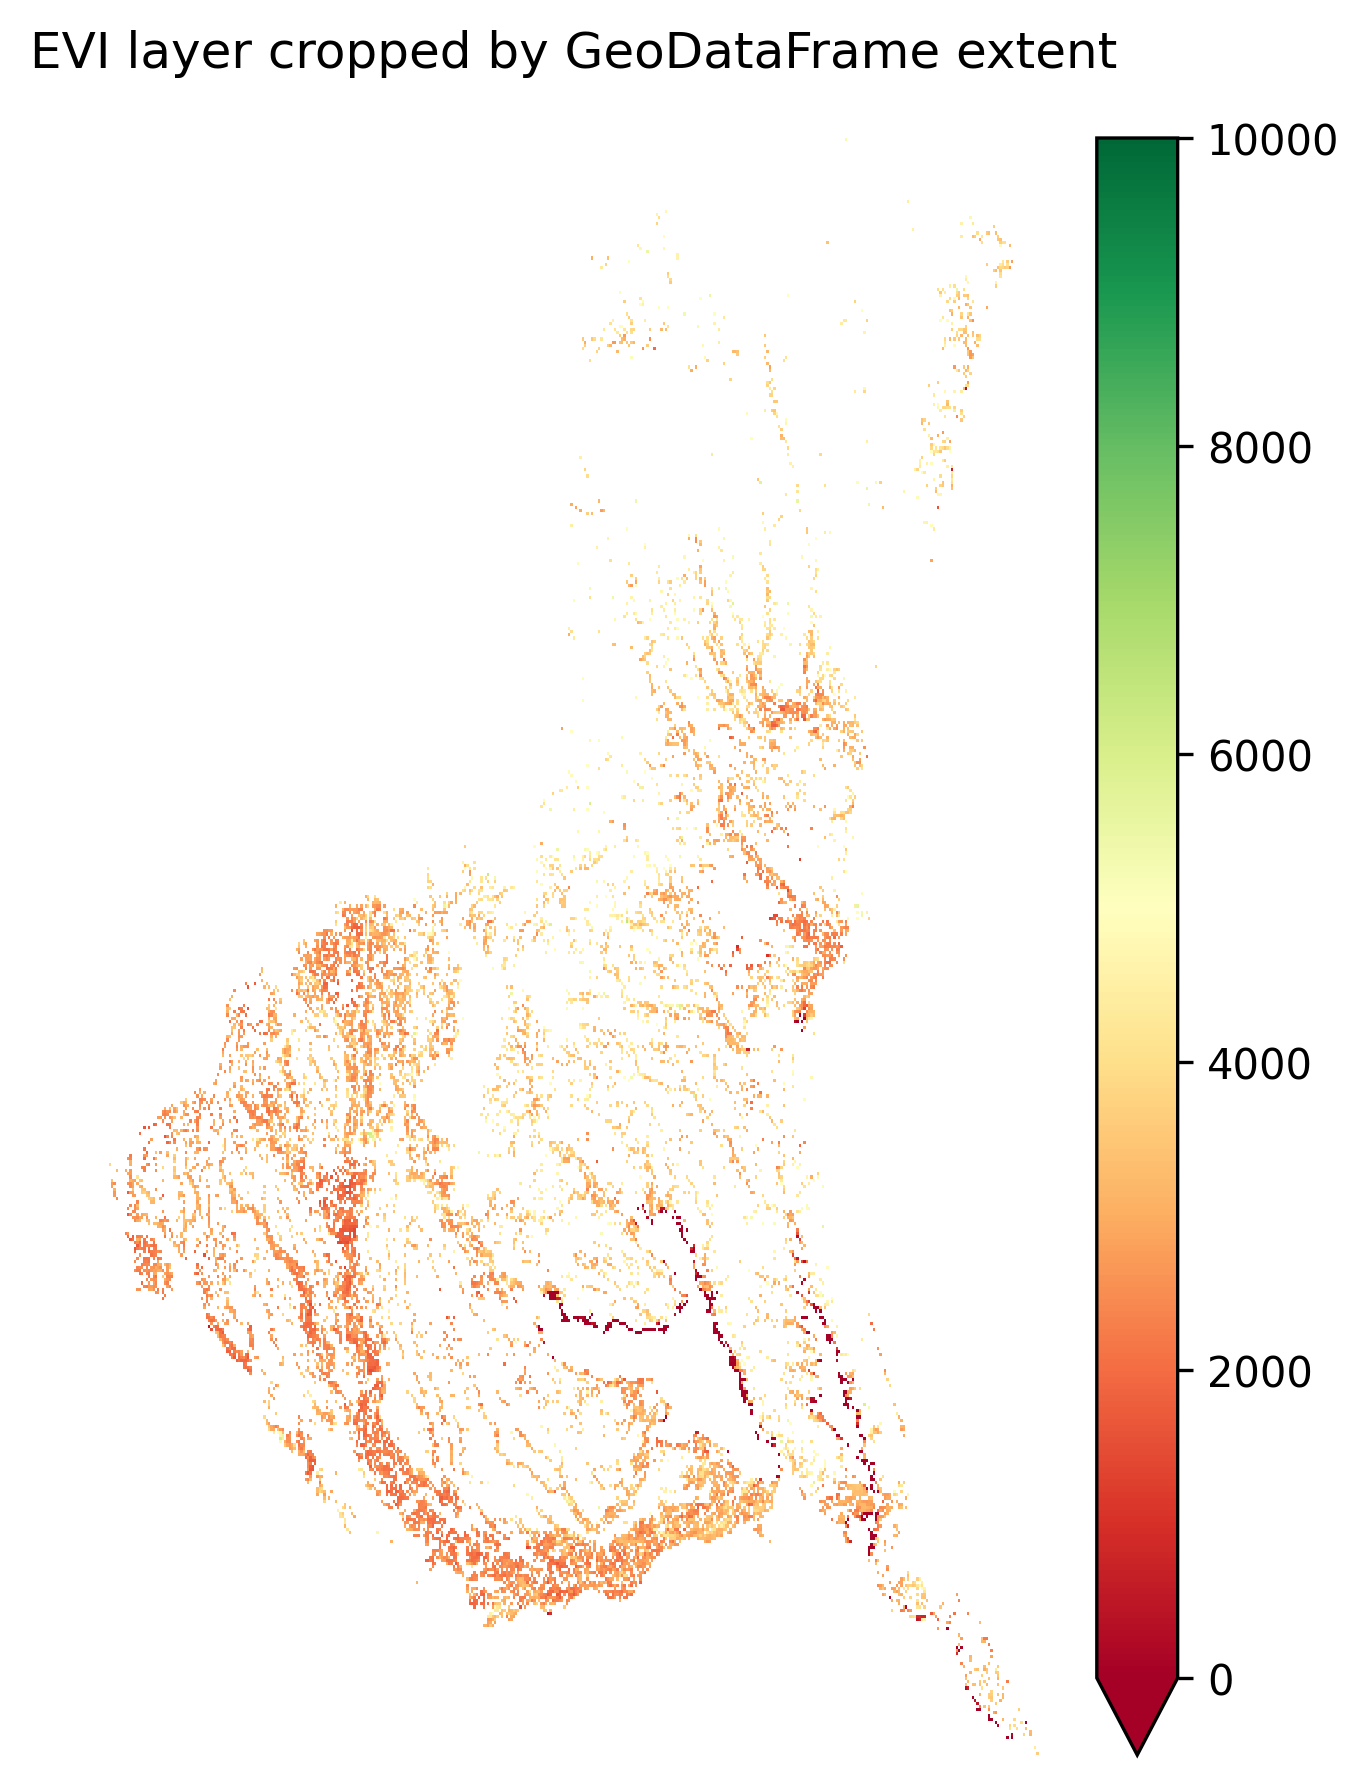

In [ ]:
# EVIを筆ポリゴンで切り抜く
# eviCropped = evi2007.rio.clip(ibarakiDf.geometry.apply(mapping), ibarakiDf.crs) # rasterioが1.2より低いバージョンの場合
eviCropped = evi2007.rio.clip(ibarakiDf.geometry, ibarakiDf.crs)
# 上のようにベクターのCRSを指定しておけば、異なるCRSを持っていた場合、ベクター側のCRSにあわせて切り抜くことができます
# 今回は事前に変更していますので、こちらのオプションはなくても大丈夫です
f, ax = plt.subplots(figsize=(5, 7))
eviCropped.plot(ax=ax, vmin=0, vmax=10000, cmap='RdYlGn')
ax.set(title="EVI layer cropped by GeoDataFrame extent")
ax.set_axis_off()
# plt.colorbar()
plt.show()


ポリゴン内のみの画像を切り取ることができました。

In [ ]:
# xarrayのデータフレーム化
eviCroppedDf = eviCropped.to_dataframe('evi') # 値の名前をeviにします

# データフレームの確認
eviCroppedDf.head()

band  spatial_ref  evi
y            x                                    
4.086753e+06 382780.892588     1            0  NaN
             383030.892588     1            0  NaN
             383280.892588     1            0  NaN
             383530.892588     1            0  NaN
             383780.892588     1            0  NaN

-3000は欠損を意味します。統計量をまとめるときに値がおかしくならないように、NAに変更しましょう。

https://lpdaac.usgs.gov/products/mod13q1v006/

In [ ]:
eviCroppedDf.loc[eviCroppedDf.evi == -3000,'evi'] = np.nan
eviCroppedDf.head()

band  spatial_ref  evi
y            x                                    
4.086753e+06 382780.892588     1            0  NaN
             383030.892588     1            0  NaN
             383280.892588     1            0  NaN
             383530.892588     1            0  NaN
             383780.892588     1            0  NaN

In [ ]:
# 画像全体の平均値を取得します
np.nanmean(eviCroppedDf.evi)

3066.321

一連の流れを再度確認します。

- pymodisを利用して、MOD13Q1のEVI画像を取得
- 茨城県の筆ポリゴンを取得
- 筆ポリゴンから水田のみを取得
- 筆ポリゴンを利用して、EVI画像の刈り込み(Cropping)
- データフレームから平均値の取得

でした。

EVIは2007年から2018年まで取得しています。筆ポリゴンを用いて画像を刈り込む流れは上と全く同じです。

In [ ]:
filenameEVI = sorted(glob.glob('/content/drive/MyDrive/average_EVI/*.tif'))
# EVI画像の読み込み
xds = [rxr.open_rasterio(file,masked=True).squeeze() for file in filenameEVI]

In [ ]:
def calcMean(eviXds, cropExt):
  eviMean = []
  for i in range(len(eviXds)):
    xds = eviXds[i]
    # EVIを筆ポリゴンで刈り取る
    xdsCropped = xds.rio.clip(cropExt.geometry.apply(mapping), cropExt.crs)
    # データフレームへ
    xdsCroppedDf = xdsCropped.to_dataframe('evi')
    # -3000を欠損値へ
    xdsCroppedDf.loc[xdsCroppedDf.evi == -3000,'evi'] = np.nan
    # 画像全体の平均値を取得します。
    eviMean.append(np.nanmean(xdsCroppedDf.evi))

  return eviMean

In [ ]:
# 平均値の取得（＊計算に時間がかかります。５分〜１０分程度）
avgEVI = calcMean(xds,ibarakiDf)

# 結果の表示
avgEVI

[3066.321,
 3042.6687,
 2877.6729,
 2867.4644,
 2976.9685,
 3617.336,
 3538.931,
 3501.1956,
 3004.5435,
 2961.8457,
 3286.5476,
 3125.667]

In [ ]:
year = [str(x) for x in range(2007,2019,1)]
eviDf = pd.DataFrame({'year':year,'evi':avgEVI})
eviDf.set_index("year",inplace=True) # yearをインデックスにする
eviDf.head()

,evi
year,
2007,3066.321045
2008,3042.668701
2009,2877.672852
2010,2867.464355
2011,2976.968506


これで、2007年から2018年までのEVIが取得できました。

In [ ]:
eviDf.to_csv('/content/drive/MyDrive/evi.csv',index=False)
eviDf = pd.read_csv('/content/drive/MyDrive/evi.csv')

結果を描画します。

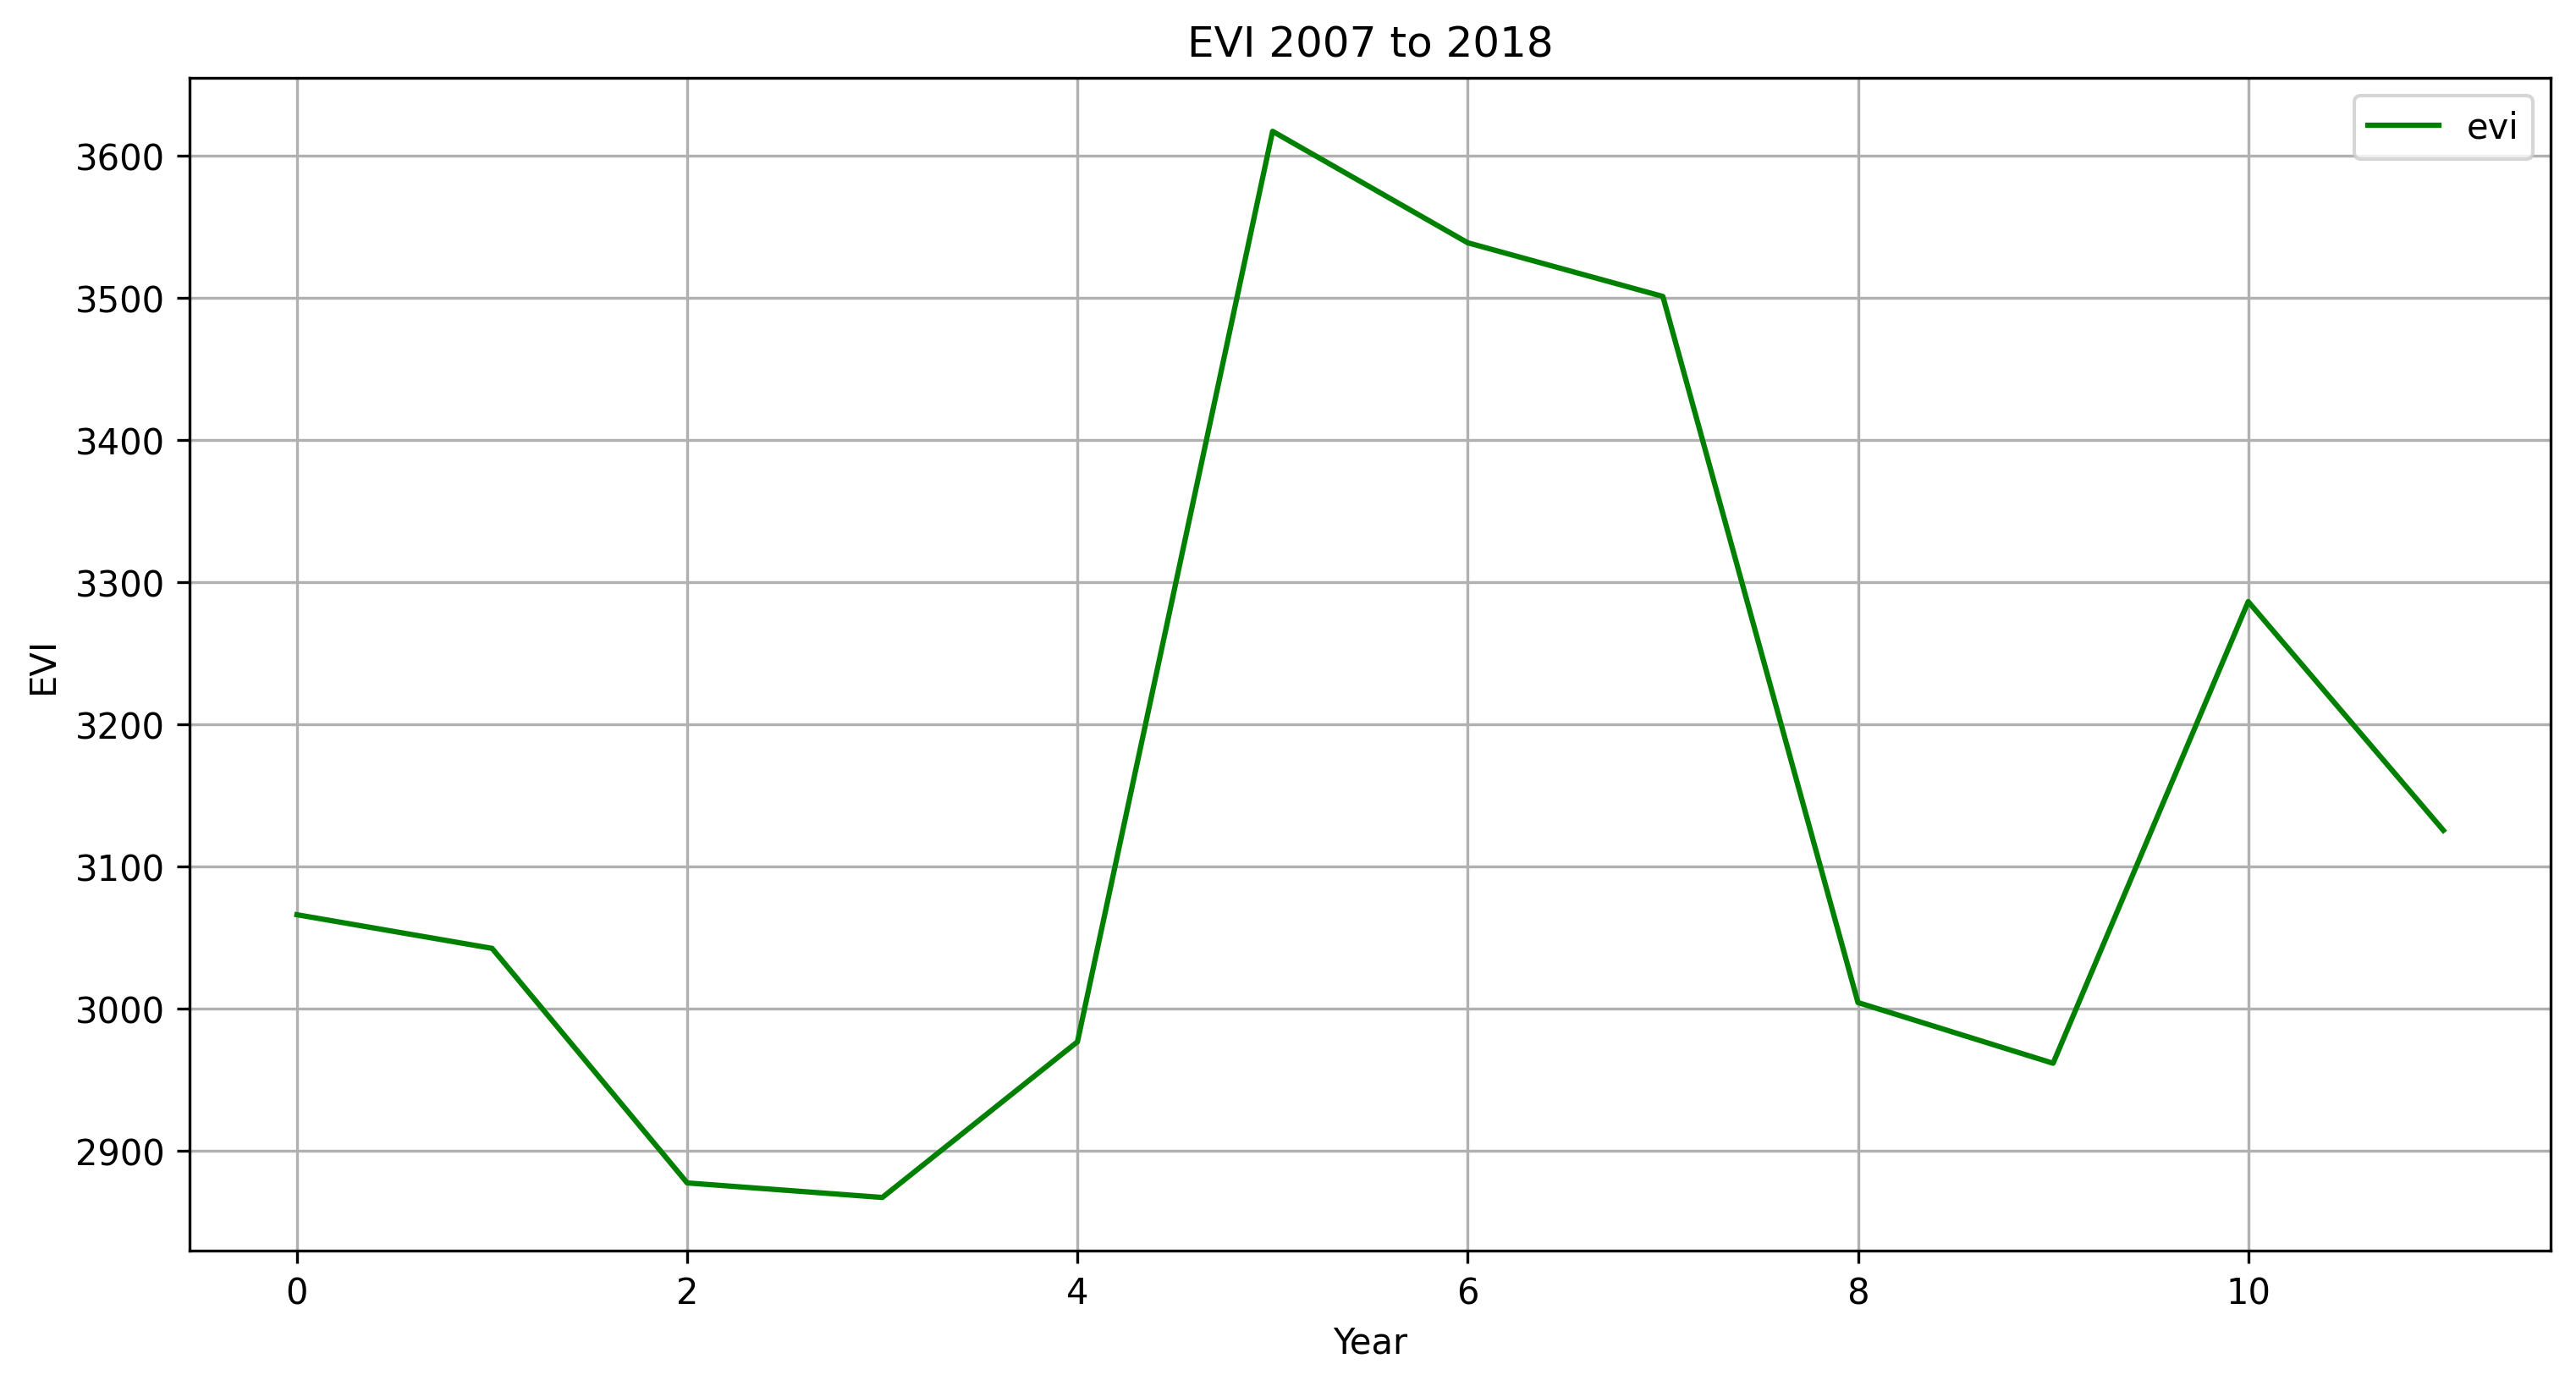

In [ ]:
eviDf.plot(title="EVI 2007 to 2018",color='g',grid=True,label="EVI",xlabel = "Year",ylabel = "EVI",figsize=(12,6))
plt.legend()
plt.show()

### AMeDASデータの取得

日本の気象データは、気象庁の地域気象観測システム「AMeDAS（Automated Meteorological Data Acquisition System）」が取得しています。詳細については[気象庁のサイト](https://www.jma.go.jp/jma/kishou/know/amedas/kaisetsu.html)を参照してください。日射量は「日照時間」として6分単位で観測されています。

気象庁の[過去の気象データ・ダウンロードページ](https://www.data.jma.go.jp/gmd/risk/obsdl/)（下図参照）で、茨城県の2007年から2018年までの日照時間のデータをCSV形式でダウンロードします。

チェックを入れている観測局のデータのみを取得しています。





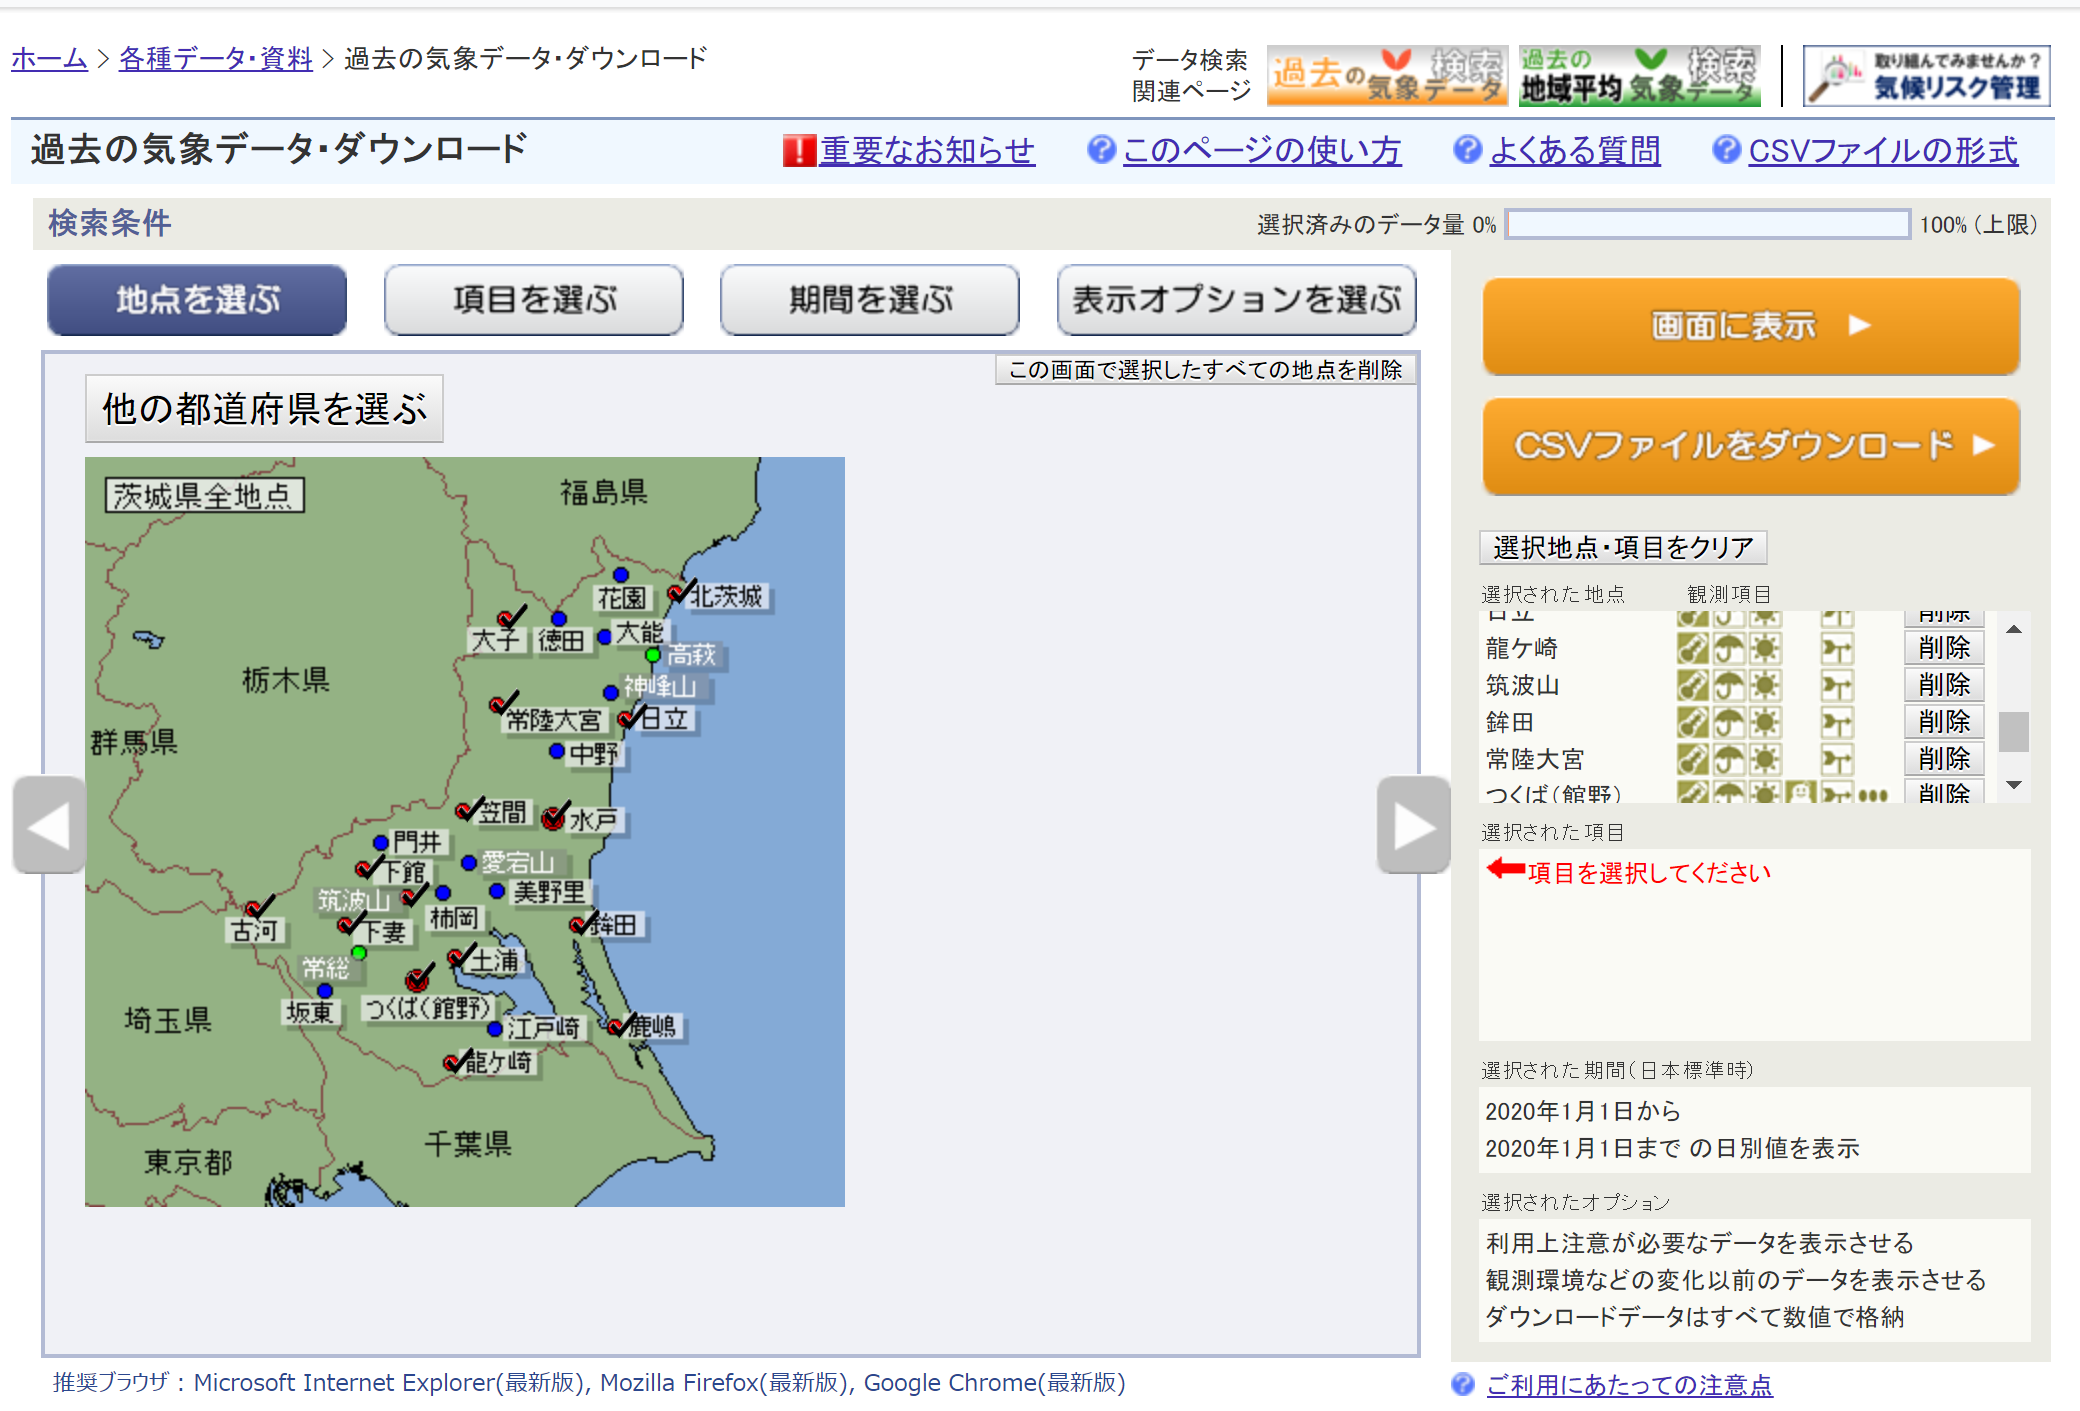


### 欠損値があるデータの削除

取得したデータAMeDASデータには欠損値が含まれる場合があるので、CSVファイルを調べ、欠損値がある場合にはそのデータを削除します。

In [ ]:
#csvデータの読み込み
#csv_pathは適宜ダウンロードしたcsvファイルが保存されいているディレクトリに変更してください。

csv_path = "/content/drive/MyDrive/ColabNotebooks/satelliteBook-main/notebooks/chapter4/ibaraki_amedas.csv"
df_ame = pd.read_csv(csv_path,skiprows = 2,encoding = "shift-jis")

In [ ]:
df_ame.head()

,Unnamed: 0,大子,大子.1,大子.2,常陸大宮,常陸大宮.1,常陸大宮.2,北茨城,北茨城.1,北茨城.2,...,龍ケ崎.2,鹿嶋,鹿嶋.1,鹿嶋.2,鉾田,鉾田.1,鉾田.2,土浦,土浦.1,土浦.2
0,年月,日照時間(時間),日照時間(時間),日照時間(時間),日照時間(時間),日照時間(時間),日照時間(時間),日照時間(時間),日照時間(時間),日照時間(時間),...,日照時間(時間),日照時間(時間),日照時間(時間),日照時間(時間),日照時間(時間),日照時間(時間),日照時間(時間),日照時間(時間),日照時間(時間),日照時間(時間)
1,NaN,NaN,品質情報,均質番号,NaN,品質情報,均質番号,NaN,品質情報,均質番号,...,均質番号,NaN,品質情報,均質番号,NaN,品質情報,均質番号,NaN,品質情報,均質番号
2,2007/7,77.8,8,1,54.8,8,1,94.6,8,1,...,1,94.1,8,1,82.0,8,1,57.9,8,1
3,2007/8,169.4,8,1,165.5,8,1,229.3,8,1,...,1,250.4,8,1,224.9,8,1,192.9,8,1
4,2007/9,114.8,8,1,113.9,8,1,150.4,8,1,...,1,156.2,8,1,141.4,8,1,125.3,8,1


In [ ]:
# 取得したcsvから観測地点の名前を取り出します
import re
re_kanji = re.compile(r'.+[\u4E00-\u9FD0]$')

colnameList = []
for colname in df_ame.columns:
  if re_kanji.match(colname) != None:
    colnameList.append(colname)
# columnList = [re_kanji.match(i) for i in df_ame.columns]

# 結果の表示
colnameList

['大子',
 '常陸大宮',
 '北茨城',
 '高萩',
 '日立',
 '笠間',
 '下館',
 '下妻',
 '常総',
 '古河',
 '龍ケ崎',
 '鹿嶋',
 '鉾田',
 '土浦']

In [ ]:
# 必要なデータは二行目以降
df_ame = df_ame[2:].reset_index(drop=True)
# 日付データへの変更
df_ame['Unnamed: 0'] = pd.to_datetime(df_ame['Unnamed: 0'])
# 年データの追加
df_ame['year'] = df_ame['Unnamed: 0'].dt.year

df_ame.head() # 確認

  df_ame['Unnamed: 0'] = pd.to_datetime(df_ame['Unnamed: 0'])



,Unnamed: 0,大子,大子.1,大子.2,常陸大宮,常陸大宮.1,常陸大宮.2,北茨城,北茨城.1,北茨城.2,...,鹿嶋,鹿嶋.1,鹿嶋.2,鉾田,鉾田.1,鉾田.2,土浦,土浦.1,土浦.2,year
0,2007-07-01,77.8,8,1,54.8,8,1,94.6,8,1,...,94.1,8,1,82.0,8,1,57.9,8,1,2007
1,2007-08-01,169.4,8,1,165.5,8,1,229.3,8,1,...,250.4,8,1,224.9,8,1,192.9,8,1,2007
2,2007-09-01,114.8,8,1,113.9,8,1,150.4,8,1,...,156.2,8,1,141.4,8,1,125.3,8,1,2007
3,2008-07-01,110.6,8,1,121.3,8,2,147.0,8,1,...,178.7,8,1,151.4,8,1,137.0,8,2,2008
4,2008-08-01,106.2,8,1,117.9,8,2,115.4,8,1,...,166.3,8,1,143.4,8,1,132.7,5,2,2008


In [ ]:
# 必要な列の取得
df_station = df_ame.loc[:,colnameList].copy()

# または以下の方法でもできます
# 必要な列は、日照時間のみ
# 必要な列は３列ごとに現れる
# selColNum = [x for x in range(1,44,3)]

df_station.head()

,大子,常陸大宮,北茨城,高萩,日立,笠間,下館,下妻,常総,古河,龍ケ崎,鹿嶋,鉾田,土浦
0,77.8,54.8,94.6,NaN,64.7,66.4,79.1,37.2,NaN,63.3,60.6,94.1,82.0,57.9
1,169.4,165.5,229.3,NaN,191.3,200.7,237.9,168.6,NaN,209.6,196.1,250.4,224.9,192.9
2,114.8,113.9,150.4,NaN,135.2,117.3,118.8,110.5,NaN,125.0,127.2,156.2,141.4,125.3
3,110.6,121.3,147.0,NaN,139.9,96.1,143.0,140.1,NaN,138.4,161.3,178.7,151.4,137.0
4,106.2,117.9,115.4,NaN,124.4,102.1,138.5,140.3,NaN,126.3,147.2,166.3,143.4,132.7


In [ ]:
# データ結合
df_sunshine = pd.concat([df_ame.iloc[:,[0,-1]],df_station],axis=1).rename(columns={'Unnamed: 0':'date'})

# 日付をindexへ
df_sunshine = df_sunshine.set_index('date')
# objectになっているので、numericへ
df_sunshine = df_sunshine.apply(pd.to_numeric)

df_sunshine.head()

,year,大子,常陸大宮,北茨城,高萩,日立,笠間,下館,下妻,常総,古河,龍ケ崎,鹿嶋,鉾田,土浦
date,,,,,,,,,,,,,,,
2007-07-01,2007,77.8,54.8,94.6,NaN,64.7,66.4,79.1,37.2,NaN,63.3,60.6,94.1,82.0,57.9
2007-08-01,2007,169.4,165.5,229.3,NaN,191.3,200.7,237.9,168.6,NaN,209.6,196.1,250.4,224.9,192.9
2007-09-01,2007,114.8,113.9,150.4,NaN,135.2,117.3,118.8,110.5,NaN,125.0,127.2,156.2,141.4,125.3
2008-07-01,2008,110.6,121.3,147.0,NaN,139.9,96.1,143.0,140.1,NaN,138.4,161.3,178.7,151.4,137.0
2008-08-01,2008,106.2,117.9,115.4,NaN,124.4,102.1,138.5,140.3,NaN,126.3,147.2,166.3,143.4,132.7


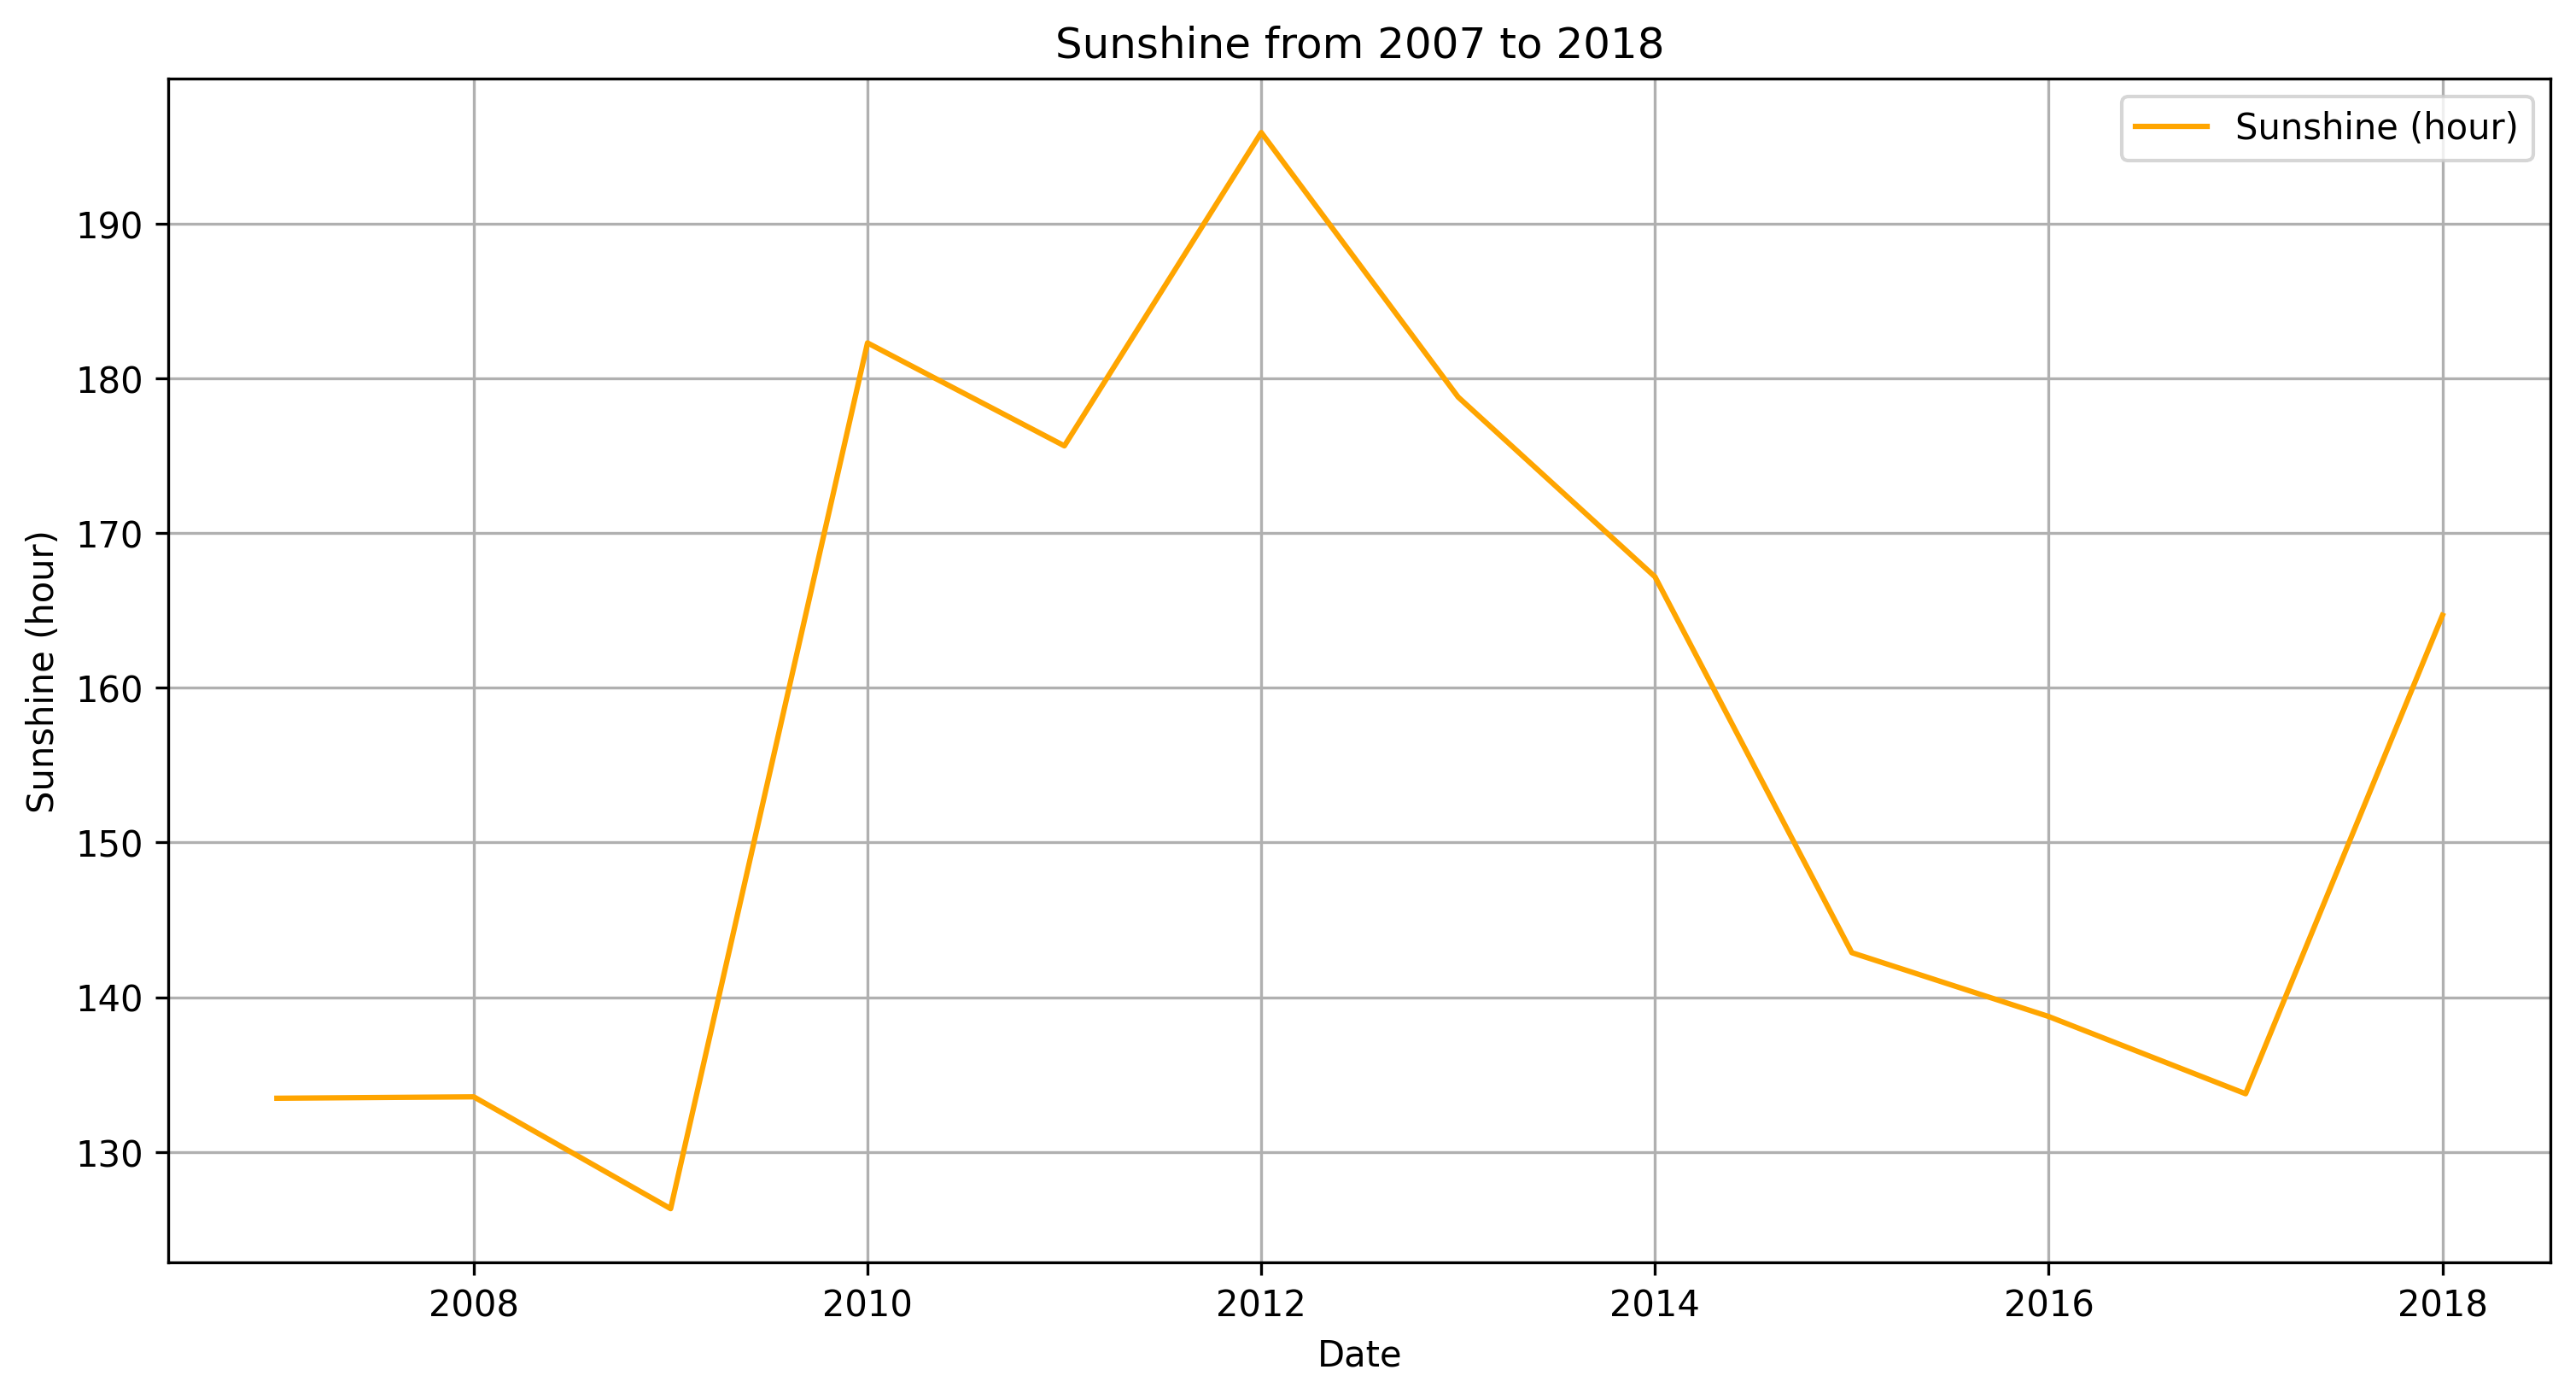

In [ ]:
# 年平均を取得します
yearlySunshine = df_sunshine.groupby('year').mean().mean(axis=1)

# 描画を行います
yearlySunshine.plot(title="Sunshine from 2007 to 2018",color='orange',grid=True,label="Sunshine (hour)",xlabel = "Date",ylabel = "Sunshine (hour)",figsize=(12,6))
plt.legend()
plt.show()

先ほどのEVIと傾向が似ているように見えますね。

### 日射量とEVIの比較

日射量の代表値とEVIの関係をグラフで表してみましょう。


In [ ]:
eviDf['meanSunshine'] = yearlySunshine.values

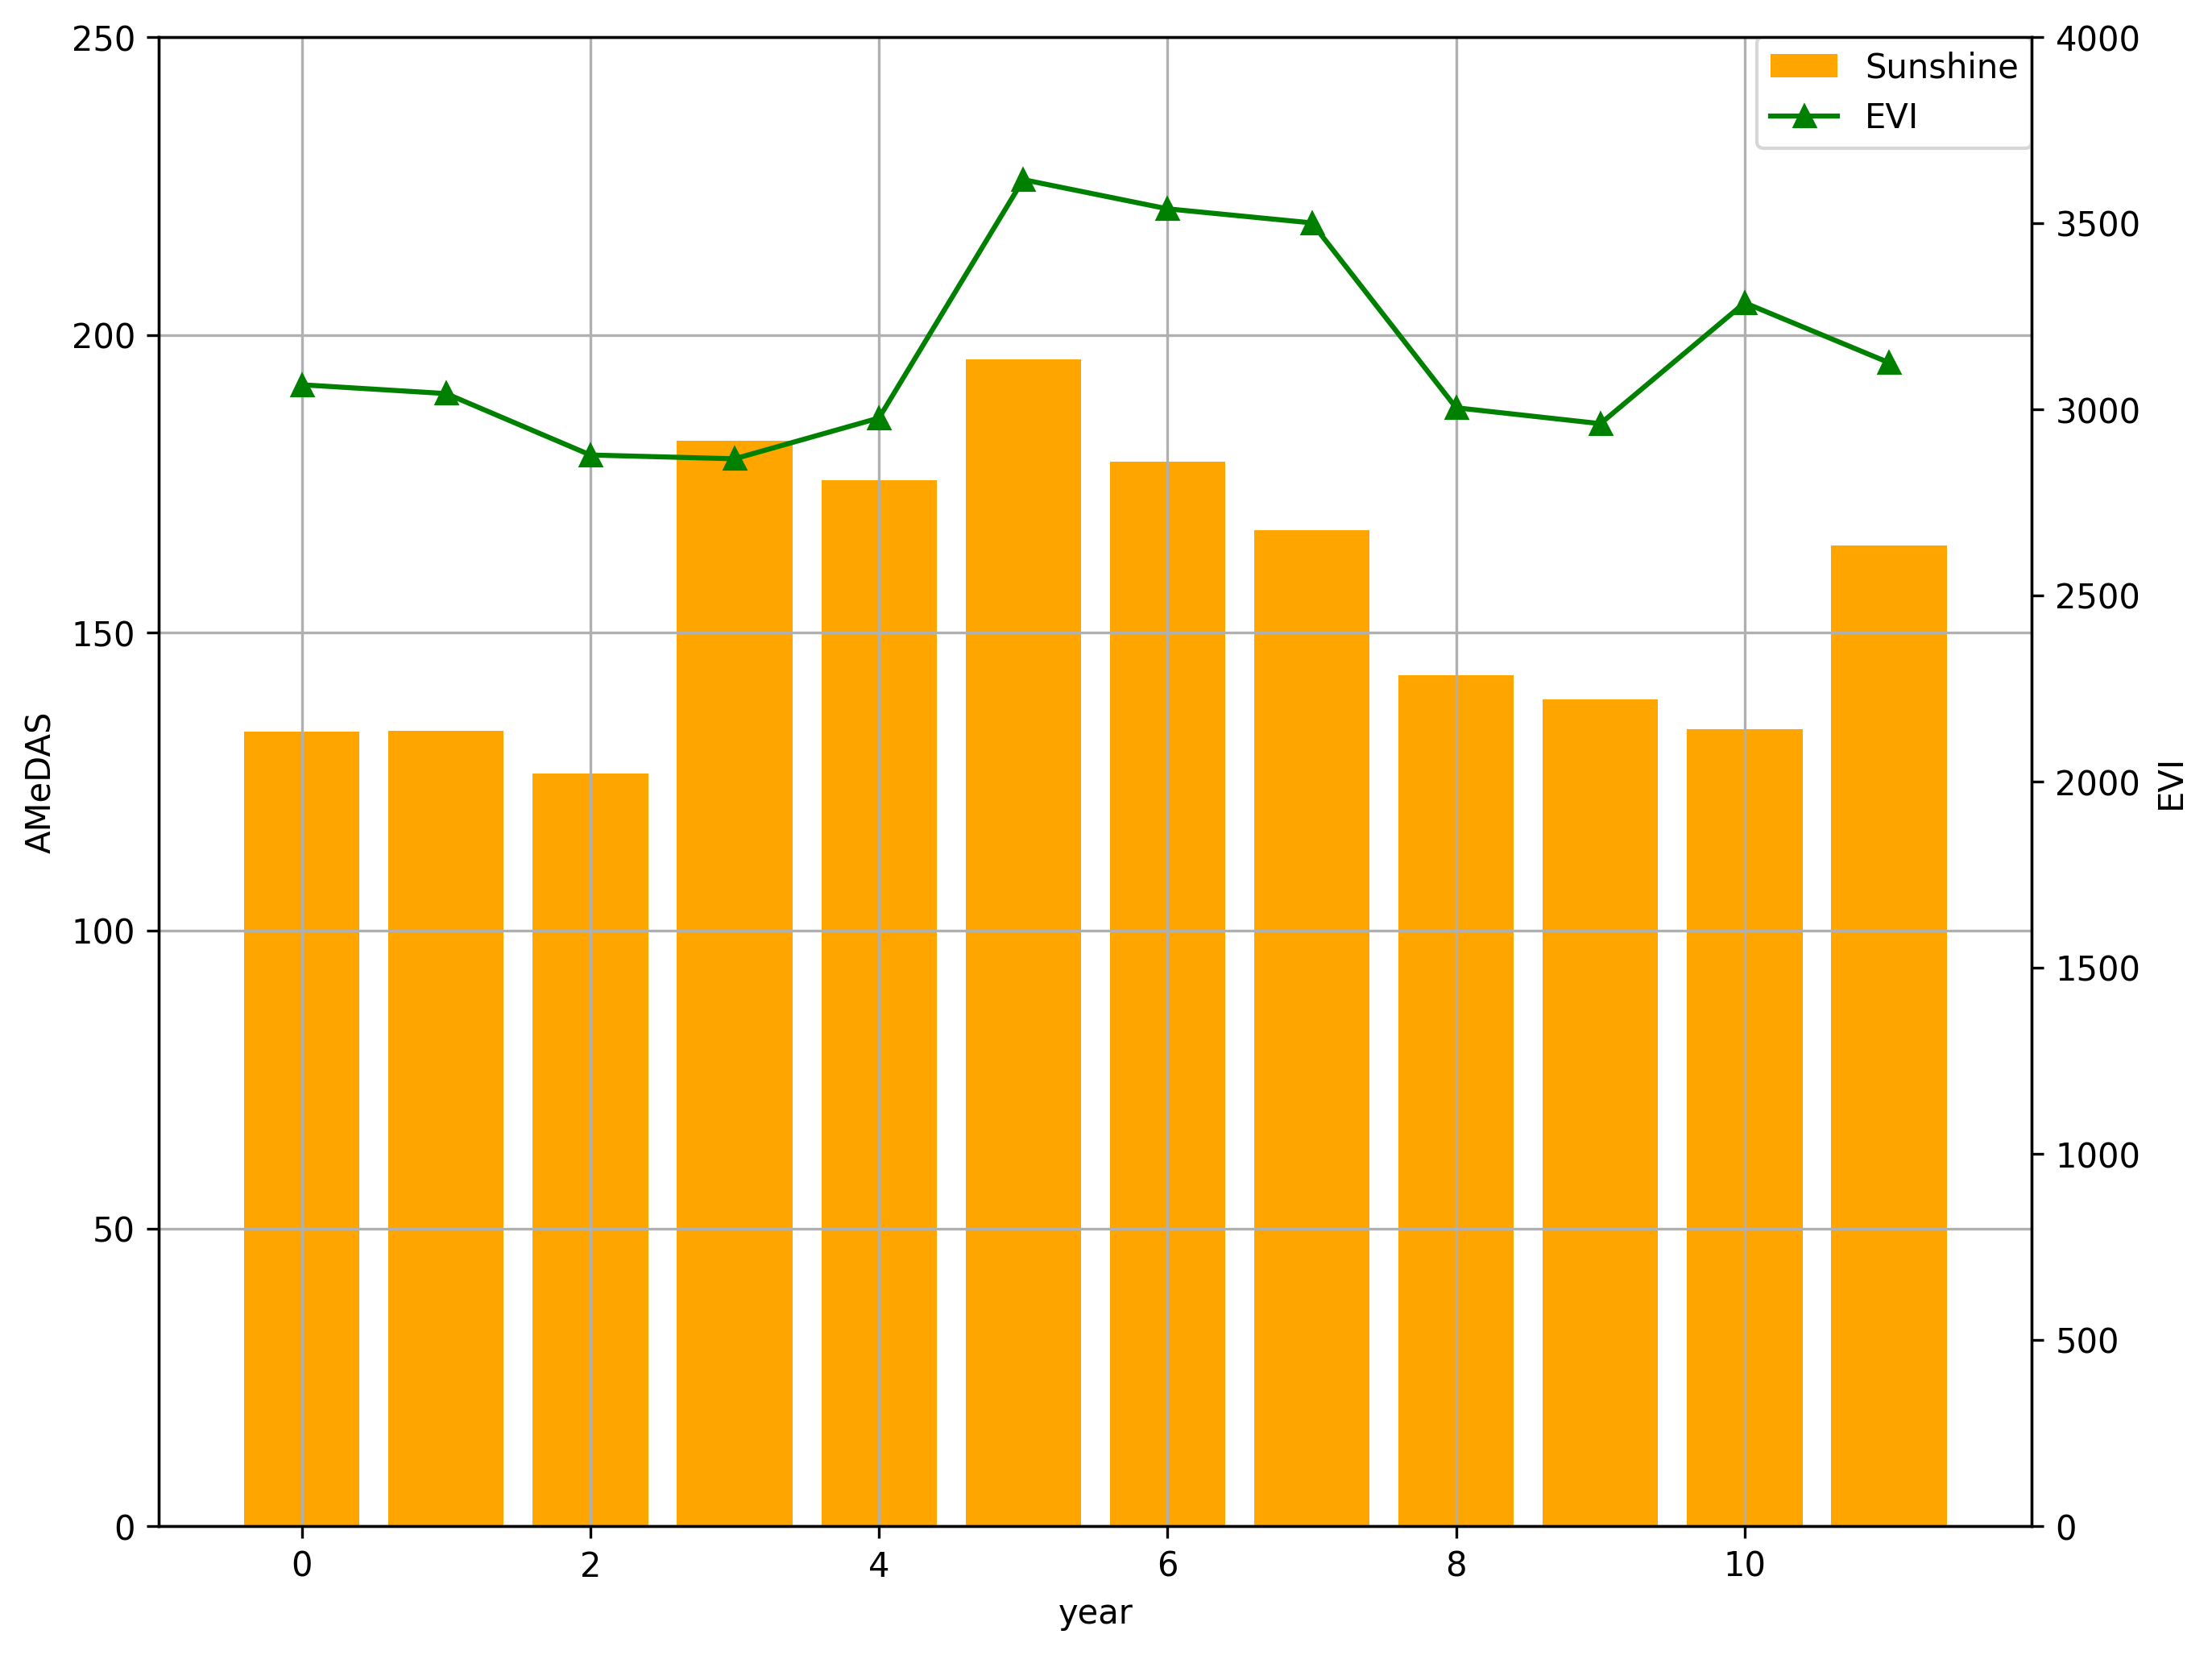

In [ ]:
#ax1をAMeDASの日射量、ax2をEVIとして描画
fig, ax1 = plt.subplots(1,1,figsize=(10,8))
ax2 = ax1.twinx()
ax1.bar(eviDf.index,eviDf['meanSunshine'],color="orange",label="Sunshine")
ax2.plot(eviDf["evi"],linestyle='solid',color='g',marker='^',label='EVI')
ax1.set_ylim(0,250)
ax1.set_ylabel("AMeDAS")
ax1.set_xlabel("year")
ax2.set_ylim(0,4000)
# ax2.set_ylim(0,0.20)
ax2.set_ylabel("EVI")
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1+handler2,label1+label2,borderaxespad=0)
ax1.grid(True)
fig.show()

このグラフから、日射量とEVIとの間に類似した傾向があることが見て取れます。日照時間が長ければ長いほど、水稲が順調に生育しているようです。

## 水稲収量の予測

ここまで、MODISデータから2007年から2018年の茨城県の水田のEVIを作成し、日射量による影響を見てみました。次に、2007年から2017年における水稲収量の実測値とEVIを用いて単回帰分析を行います。

また、予測式の検証として2018年のEVIを作成した予測式に当てはめ、同年の収量を予測し、推定値と実測値で比較してみることにします。

### 収量の実測値の取得

米の収量の実測値は、総務省統計局が運営するポータルサイト「e-Stat」から入手できます。このサイトは各府省が公表する統計データを管理、提供しており、APIでデータを入手することもできます。

米の収量は、kg/10aの単位で提供されてています。1a（アール）は100平方メートル（10m x 10m）です。

APIを利用するために、まずe-Statの[ユーザ登録のページ](https://www.e-stat.go.jp/mypage/user/preregister/)で登録してください。

今回は、[作物統計調査の水稲のデータセット](https://www.e-stat.go.jp/stat-search/database?page=1&query=%E4%BD%9C%E7%89%A9%E7%B5%B1%E8%A8%88%E8%AA%BF%E6%9F%BB%E3%80%80%E6%B0%B4%E7%A8%B2%E3%80%80%E8%8C%A8%E5%9F%8E%E7%9C%8C&layout=dataset&statdisp_id=0003293480&metadata=1&data=1)から、茨城県を対象に2007年から2018年の収量情報を取得します。

2007年から2010年における県全体の収量がデータベース上で提供されていないことから、各市町村における収量を集計し、全体で平均値化することでその年の県全体の収量としました。

Tellusの[How to useのページ](https://www.tellusxdp.com/ja/howtouse/dev/20200221_000256.html)でも、API経由でe-Statから収量の情報を入手する方法を説明しているので参考にしてください。


In [ ]:
def get_json(base_url,params):
	params_str = urllib.parse.urlencode(params)
	url = base_url + params_str
	json = requests.get(url).json()
	return json

In [ ]:
# APIを登録した際に発行されるURL
appID = "1b4d9ddb5084462e3191cbc3fc014810c706e4aa" # appIdを設定
base_url = "http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData?"
params = {"appId":appID,"lang":"J","statsDataId":"0003293480","metaGetFlg":"Y","cntGetFlg":"N","sectionHeaderFlg":"1"}

json = get_json(base_url, params)

JSONから必要なエリアのみのデータを取得します。各都道府県および市町村にIDが降られているので、e-Statのデータベースより調べリスト化します。[こちらのデータベース](https://www.e-stat.go.jp/municipalities/cities)から市町村区コードを探すことができます。検索結果はcsvとhtmlでダウンロードが可能です。csvのファイルであれば、コードの先頭から0が抜けていますので、追加することを忘れないようにしましょう。

今回は該当のページの表データから標準地域コードを抜き出します。

In [ ]:
# スクレイピングのためのライブラリインポート
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URLの指定
urls = ["https://www.e-stat.go.jp/municipalities/cities/areacode?date_year=2021&date_month=10&date_day=4&pf%5B8%5D=8&ht=&city_nm=&city_kd%5B4%5D=4&city_kd%5B5%5D=5&city_kd%5B6%5D=6&city_kd%5B7%5D=7&op=search&keyword_kd=code&item%5B0%5D=htCode&item%5B1%5D=todoNm&item%5B2%5D=parentCityNm&item%5B3%5D=parentCityKana&item%5B4%5D=selfCityNm&item%5B5%5D=selfCityKana&item%5B6%5D=htCodeSDate&item%5B7%5D=jiyuId&sort%5B0%5D=htCode-asc&choices_to_show%5B0%5D=cityType&choices_to_show%5B1%5D=kasoFlg&choices_to_show%5B2%5D=htCodeKokujiDate&choices_to_show%5B3%5D=htCodeKokujiNo&choices_to_show%5B4%5D=htCodeEDate&choices_to_sort%5B0%5D=kasoFlg&choices_to_sort%5B1%5D=htCodeSDate&choices_to_sort%5B2%5D=htCodeEDate&choices_to_sort%5B3%5D=htCodeKokujiDate&choices_to_sort%5B4%5D=htCodeKokujiNo&choices_to_sort_value%5B0%5D=htCode-desc&choices_to_sort_value%5B1%5D=kasoFlg-asc&choices_to_sort_value%5B2%5D=kasoFlg-desc&choices_to_sort_value%5B3%5D=htCodeSDate-asc&choices_to_sort_value%5B4%5D=htCodeSDate-desc&choices_to_sort_value%5B5%5D=htCodeEDate-asc&choices_to_sort_value%5B6%5D=htCodeEDate-desc&choices_to_sort_value%5B7%5D=htCodeKokujiDate-asc&choices_to_sort_value%5B8%5D=htCodeKokujiDate-desc&choices_to_sort_value%5B9%5D=htCodeKokujiNo-asc&choices_to_sort_value%5B10%5D=htCodeKokujiNo-desc&form_id=city_areacode_form&source=setup&page={}".format(i) for i in range(1,4)]

def getTable(url):
    with requests.Session() as req:
        r = req.get(url)
        soup = BeautifulSoup(r.content, 'html.parser')
        r = req.post(url)
        df1 = pd.read_html(r.content, attrs={
                          'class': 'stat-inspect-table js-inspect-table stat-areacode-list-table __fix'}, converters = {'標準地域コード': str})[0]
        df2 = pd.read_html(r.content, attrs={
                          'class': 'stat-inspect-table js-inspect-table stat-areacode-list-table'}, parse_dates=['廃置分合等施行年月日'])[0]
        res = pd.concat([df1,df2],axis=1)
        filename = "blockCode" + url.split('page=')[1] + '.csv'
        print(filename)
        res.to_csv(filename, index=False)
        return res

定義した関数を実行し、取得したテーブルデータをcsvにして保存します。

In [ ]:
[getTable(url) for url in urls]

ValueError: Missing column provided to 'parse_dates': '廃置分合等施行年月日'

In [ ]:
path = r'/content/' # use your path
all_files = glob.glob(path + "/block*.csv")
rows = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    rows.append(df)

ibarakiID = pd.concat(rows, axis=0, ignore_index=True)
ibarakiID.head()

In [ ]:
# csvをダウンロードした場合
# ibarakiID = pd.read_csv('/content/FEA_hyoujun-20210613103607.csv',encoding='shift_jis') #ダウンロードしたファイルを読み込む

In [ ]:
# 茨城県の市町村IDを取得
ID_list =ibarakiID['標準地域コード'].astype('str').to_list()
ID_list = ['0'+ id for id in ID_list] # 0追加

In [ ]:
# # または自分で調べて打つこともできます（上記サイトから）
# # 茨城県の市町村IDをリスト化
# ID_list = ["08201","08202","08203","08204","08205","08207",
#              "08208","08210","08211","08212","08214","08215",
#              "08216","08217","08219","08220","08221","08222",
#              "08223","08224","08225","08226","08227","08228",
#              "08229","08230","08231","08232","08233","08234",
#              "08235","08236","08302","08309","08310","08341",
#              "08364","08442","08443","08447","08521","08542","08546","08564"]

In [ ]:
#データのダウンロード
df_yield_base = pd.DataFrame()

for ID in ID_list:
  # valuesを探す
  all_values = pd.DataFrame(json['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])
  # @cat01が110は収量(kg/10a) @areaはリストにあるIDで指定し、茨城県の市町村ごとのデータをループ処理で取得する。
  values = all_values[(all_values["@cat01"] == "110") & (all_values["@area"] == ID)]
  # 取得した時間の末尾に000000がつくので削除
  values = values.replace("0{6}$", "", regex=True)
  values = values.rename(columns = {"@time": "年", "$": "10aあたりの収量","@unit": "単位"})
  values = values.astype({"10aあたりの収量":"int32"})
  df_yield_base = df_yield_base.append(values)

各市町村の収量を集計し、平均値化することでその年における茨城県の収量を算出します。

In [ ]:
year =[str(x) for x in range(2007,2019,1)]

df_yield = pd.DataFrame(columns=["年","収量合計[kg/10a]"])

#茨城県内の収量の平均値を算出
for y in year:
  ind = df_yield_base[df_yield_base["年"] == y]
  yield_ave = (ind["10aあたりの収量"].mean())
  df_yield_sub = pd.Series([y,yield_ave], index=df_yield.columns)
  df_yield = df_yield.append(df_yield_sub, ignore_index=True)

#単位を変換した年ごとの収量合計表を表示
df_yield = df_yield.set_index("年")

df_yield

In [ ]:
eviDf = eviDf.reset_index()
df_yield = df_yield.reset_index()
dfYield = df_yield.rename(columns={'収量合計[kg/10a]':'totalYield'}).copy()
# データセットの結合
analysisDf = eviDf.merge(dfYield,how='left', left_on='year',right_on='年')
analysisDf = analysisDf.drop('年',axis=1)

analysisDf

In [ ]:
# ax1を米の収穫量、ax2をEVIとして描画
fig, ax1 = plt.subplots(1,1,figsize=(12,8))
ax2 = ax1.twinx()
ax1.bar(analysisDf['year'],analysisDf["totalYield"],color="gold",label="Yield")
ax2.plot(analysisDf["evi"],linestyle='solid',color='g',marker='^',label='EVI')
ax1.set_ylim(0,800)
ax1.set_ylabel("Rice yields")
ax1.set_xlabel("Year")
ax2.set_ylim(0,4000)
ax2.set_ylabel("EVI")
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1+handler2,label1+label2,borderaxespad=0)
ax1.grid(True)
fig.show()

このグラフを見ると、収量とEVIの傾向は概ね同じであることがわかります。ただし、2007年や2008年のように傾向が一致しない年もあり、考察が必要です。2008年は、8月中下旬が日照不足で登熟（出穂の後、種子が発育、肥大をする過程のこと）が抑制されたようですが、その後の天候回復で収量が回復したようです（[水稲の作柄に関する委員会の資料参照](https://www.maff.go.jp/j/study/suito_sakugara/05/pdf/data3.pdf)）。

### おまけ：EVIと収量の単回帰分析

これまでに取得したEVIの値と収量の実測値を使って、単回帰分析を行います。

はじめに、EVIと収量との関係性を評価するために相関係数を算出します。

In [ ]:
x = analysisDf["evi"]
y = analysisDf["totalYield"]

mod = LinearRegression()
df_x = pd.DataFrame(x)
df_y = pd.DataFrame(y)

#決定係数（R^2）を評価
mod_lin = mod.fit(df_x, df_y)
y_lin_fit = mod_lin.predict(df_x)
r2_lin = mod.score(df_x, df_y)

print('R = ' + str(round(math.sqrt(r2_lin), 2)))

計算した結果、R（相関係数）＝　0.75 となりました。

相関係数は一般的に0.4から0.7の間であれば、正の相関が認められることからEVIと収量の間に相関関係が確認することができました。

EVIと収量の間に相関関係が確認できたので、収量を目的変数、EVIを説明変数として単回帰分析で収量予測式を作成します。

In [ ]:
# 予測モデルを作成

clf = linear_model.LinearRegression()

x2 = analysisDf.evi.values.reshape(-1,1)
y2 = analysisDf.totalYield.values.reshape(-1,1)

clf.fit(x2, y2)
a = clf.coef_[0][0]
b = clf.intercept_[0]
c = clf.score(x2,y2)
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(x2, y2 ,c='#00FFFF', edgecolors="#37BAF2")

# 回帰直線の表示

plt.title('Linear regression')
plt.plot(x2, clf.predict(x2))
plt.xlabel('EVI')
plt.ylabel('Yield')
plt.grid()
plt.show()

# 各パラメータの表示 /// 表示の書き方を統一。
print("回帰係数= ", np.round(clf.coef_[0][0],2))
print("切片= ", np.round(clf.intercept_[0],2))
print("決定係数= ", np.round(clf.score(x2, y2),2))
print("収量予測式= ", "y= " + str(np.round(a,2)) + "x + " + str(np.round(b,2)))

決定係数は56%となっています。もともとデータ数が少ないため、高い値が出ても結果に信頼性がおけるかは怪しいですが、ここでは解析の流れを掴むという意味で記載しました。

圃場あたりの収穫量がわかれば、されに厳密な解析が行えます。

アルゴリズムを少ないサンプルサイズであっても頑健であるものに変更することにより、さらに精度の高い結果を得られることも考えられます（例えばランダムフォレスト）。

### おまけのおまけ：収量の予測と検証

作成した収量予測式を用いて2018年における収量を推定します。

In [ ]:
#2018年の結果を予測

#集計した値のリスト
list_2018 = [analysisDf.evi[11] ,analysisDf.totalYield[11]]

yield_est = (a * list_2018[0]) + b

print("2018年の収量予測値[kg/10a]：",np.round(yield_est,2))
print("2018年の収量実測値[kg/10a]：",np.round(list_2018[1],2))

#差分計算

yield_diff = yield_est - list_2018[1]

print("誤差[kg/10a]：",np.round(yield_diff,2))

現在、農林水産省では複数の気象データを変数とした多変量解析による予測式の作成が取り組まれています。また、作成した予測式より上位5式を選択することで、各地域に合った予測式が作成されています。

本章ではEVIのみを使った簡単な単回帰分析で予測式を作りましたが、実際には他の変数や作物ごとの収量予測モデルが使われています。今回の方法を発展させ、複数の変数を組み合わせた予測にも挑戦してみてください。